## Simulador de Recorridos ciclistas

### Importamos librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle
import time

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display
from IPython.core.display import HTML
import math as mt
py.offline.init_notebook_mode(connected=True)

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Como tenemos procesado todo en el mismo fichero, lo cargamos

#Tenemos que decidir si queremos hacer una simulación comparativa contra un resultado nuestro o contra un GPX "standar", ya que se encuentran en distinto fichero

#path = '../Entrenamientos/Procesado_Tramos.xlsx'


path = '../Entrenamientos/Procesado_Tramos_simulacion.xlsx'
df = pd.read_excel(path)

### Filtramos datos

In [3]:
#Listamos las pruebas que contiene el fichero
df["prueba"].unique()

array(['xxxxxxxx_LEVS_195_90_R_E.gpx'], dtype=object)

In [4]:
#Eliminar las filas que no tienen datos y seleccionamos la prueba que queremos simular
df = df[df["porc"]!=np.inf]

#En caso de que el fichero de entrada contenga más de una prueba, hay que seleccionar cual queremos simular
#df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [5]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,84.000000,84.000000,84.000000,84.0,84.0,84.000000,84.0,84.000000,84.000000,84.000000
mean,41.500000,1220.797619,1252.880952,0.0,0.0,507.744281,0.0,-0.587996,-0.047731,19509.435551
std,24.392622,777.046195,781.656619,0.0,0.0,693.744429,0.0,5.336408,1.819731,12154.558566
min,0.000000,0.000000,25.000000,0.0,0.0,12.158278,0.0,-9.954147,-4.645913,329.544198
25%,20.750000,529.750000,609.500000,0.0,0.0,25.516494,0.0,-4.099877,-0.565377,9742.611994
50%,41.500000,1235.500000,1266.000000,0.0,0.0,145.726222,0.0,-1.248373,0.001432,19614.673821
75%,62.250000,1779.000000,1797.500000,0.0,0.0,784.964079,0.0,2.888754,0.363841,27829.260059
max,83.000000,2663.000000,2695.000000,0.0,0.0,3454.663686,0.0,9.997376,4.950157,42624.028333


In [6]:
#Se revisa que no existan datos anómalos
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba
0,0,0,25,0,0,344.041550,0,3.492273,1.596116,329.544198,xxxxxxxx_LEVS_195_90_R_E.gpx
1,1,25,26,0,0,13.567297,0,1.574548,-0.218832,344.041550,xxxxxxxx_LEVS_195_90_R_E.gpx
2,2,26,37,0,0,168.993513,0,1.731397,0.371159,509.985494,xxxxxxxx_LEVS_195_90_R_E.gpx
3,3,37,38,0,0,17.331806,0,1.575208,-0.067596,526.602360,xxxxxxxx_LEVS_195_90_R_E.gpx
4,4,38,41,0,0,48.498332,0,3.407638,0.074144,579.260182,xxxxxxxx_LEVS_195_90_R_E.gpx


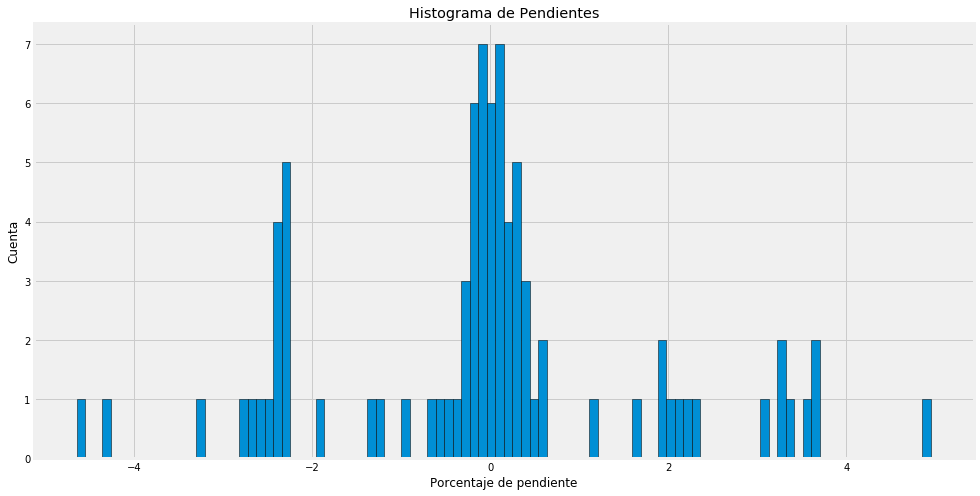

In [7]:
plt.figure(figsize = (15,8))
plt.hist(df['porc'],bins=100, edgecolor ='k')
plt.title('Histograma de Pendientes')
plt.xlabel('Porcentaje de pendiente')
plt.ylabel('Cuenta')
plt.show()

Vemos que la mayoría de tramos están centrados en porcentajes cercanos a 0, aunque también hay varios tramos de subidas y bajadas

A modo de recordatorio y por su especial importancia a la hora de ejecutar la simulación, dejamos el código de la sigmoide de potencia. Más detalles de como utilizarla se pueden encontrar en la Memoria

In [8]:
def graph(pot_min, pot_max, ff_1, ff_2):
    porc = np.arange(-10,10,0.5)

    potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
    potencia_min = pot_min+(pot_max-25-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
    potencia_max = pot_min+25+(pot_max-pot_min-25)/(1+ff_1*np.e**(ff_2*porc*-1))

    trace0 = go.Scatter(        
            x=porc,
            y=potencia,
            mode='lines',
            name='Potencia_obj')

    trace1 = go.Scatter(        
            x=porc,
            y=potencia_min,
            mode='lines',
            name='Potencia_min')

    trace2 = go.Scatter(        
            x=porc,
            y=potencia_max,
            mode='lines',
            name='Potencia_max')




    layout = go.Layout(title='Sigmoide de potencia')

    data = [trace0, trace1, trace2]

    fig = dict(data=data, layout=layout)

    py.offline.iplot(fig)
    
widgets.interact(graph, pot_min=(40,100,5), pot_max=(250,300,5), ff_1=(0.1,1,0.1), ff_2=(0.1,1,0.1))

interactive(children=(IntSlider(value=70, description='pot_min', min=40, step=5), IntSlider(value=275, descrip…

<function __main__.graph(pot_min, pot_max, ff_1, ff_2)>

In [9]:
#Prueba iterando en cada tramo con intervalos aleatorios con el modelo desarrollado CON TENSORFLOW (PRIMERA PASADA)

#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 210
pot_min = 65
pot_max = 285
ff_1 = 0.6
ff_2 = 0.35

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d, llevamos %d exitos y %d fracasos' %(fi,exito,fail))
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    bins_potencias = [0] * 30
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
   
    
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento**2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento**2)-1
            
        potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))*(np.random.randint(min_random,max_random)+100)/100
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-100,100)
        potencia_min = pot_min+(pot_max-50-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+50+(pot_max-pot_min-50)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
        
        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        #acumulamos el tiempo que se pasa en cada agrupacion de potencias
        bins_potencias[int(potencia/10)] =bins_potencias[int(potencia/10)] + nuevo_tiempo[0]
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    
    #Marcamos las salidas con dos digitos
    #0  exito
    #X1 Fuera de umbral de tolerancia
    #1X Mas de 20min en zona de alta potencia (Criterio de negocio)
    
    salida = 0
    if (potencia_media < potencia_objetivo-5) or (potencia_media > potencia_objetivo+5):
        salida = salida+1
    if sum(bins_potencias[-5:])>1200:
        salida = salida+10

    
    print("Intento %d con potencia media %d, tiempo %d y salida %d" %(fi, potencia_media, tiempo_acum, salida))
        
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5) and sum(bins_potencias[-5:])<1200:
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
        print("Tiempo por encimade de 250w:", sum(bins_potencias[-5:]))
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

Empezamos la prueba 0, llevamos 0 exitos y 0 fracasos
--- 0.9576058387756348 seconds ---
Intento 0 con potencia media 210, tiempo 5134 y salida 0
Intento 1 con potencia media 210, tiempo 5121 y salida 10
Tiempo por encimade de 250w: 1202.8378295898438
Intento 2 con potencia media 210, tiempo 5126 y salida 0
Intento 3 con potencia media 211, tiempo 5124 y salida 10
Tiempo por encimade de 250w: 1320.1200103759766
Intento 4 con potencia media 210, tiempo 5128 y salida 0
Intento 5 con potencia media 210, tiempo 5128 y salida 10
Tiempo por encimade de 250w: 1274.4543151855469
Intento 6 con potencia media 210, tiempo 5125 y salida 0
Intento 7 con potencia media 209, tiempo 5128 y salida 0
Intento 8 con potencia media 211, tiempo 5117 y salida 10
Tiempo por encimade de 250w: 1271.6705017089844
Intento 9 con potencia media 210, tiempo 5125 y salida 0
Empezamos la prueba 10, llevamos 6 exitos y 4 fracasos
--- 1.8428609371185303 seconds ---
Intento 10 con potencia media 210, tiempo 5129 y salida

Casos descartados: 42
Casos favorables: 50


In [10]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ['intento','pwr','secs','list']
ds.head()

,intento,pwr,secs,list
0,0,210.428818,5134.154785,"[[0, 220.59953763442937, 27.391504, 344.041550..."
1,2,210.557236,5126.782227,"[[0, 230.42687685344598, 28.012642, 344.041550..."
2,4,210.671768,5128.569336,"[[0, 210.7721984154128, 26.770369, 344.0415503..."
3,6,210.422333,5125.640137,"[[0, 209.1343085455767, 26.666845, 344.0415503..."
4,7,209.995956,5128.658691,"[[0, 209.1343085455767, 26.666845, 344.0415503..."


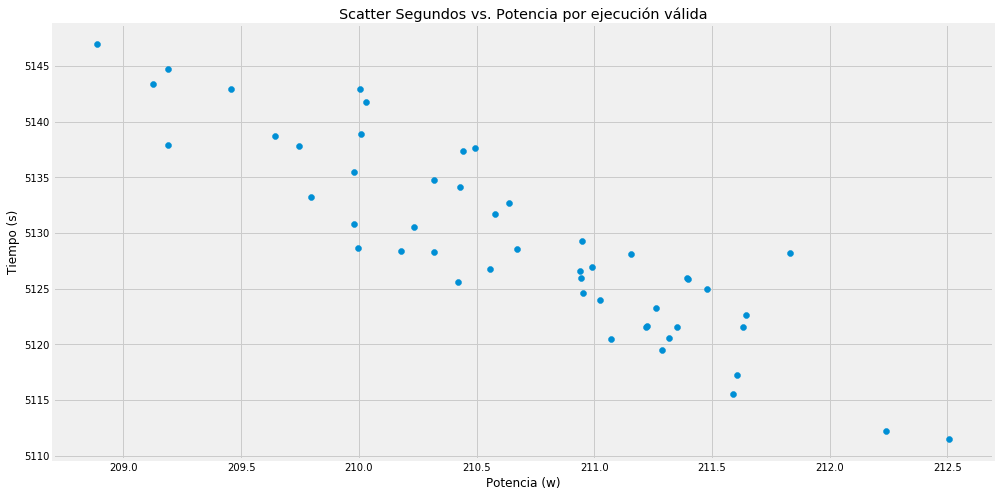

In [11]:
plt.figure(figsize = (15,8))
plt.scatter(ds['pwr'],ds['secs'])
plt.title('Scatter Segundos vs. Potencia por ejecución válida')
plt.xlabel('Potencia (w)')
plt.ylabel('Tiempo (s)')
plt.show()

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

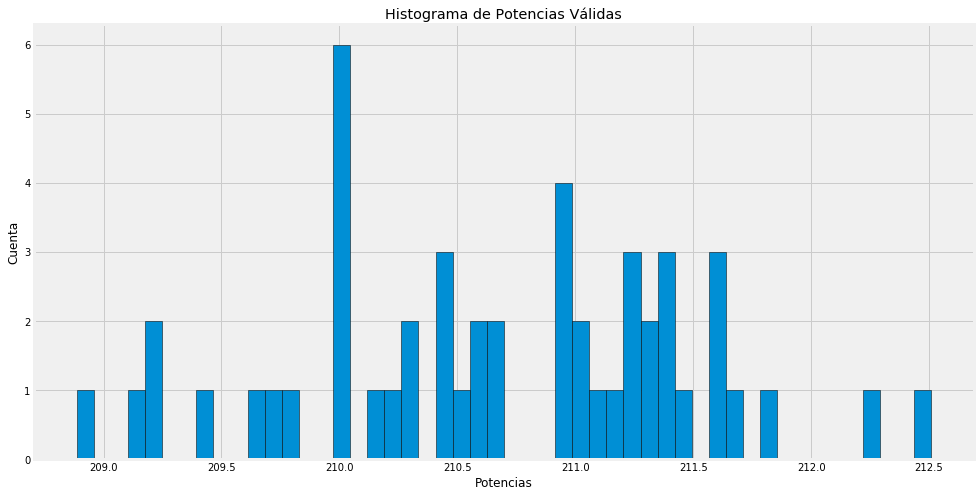

In [12]:
plt.figure(figsize = (15,8))
plt.hist(ds['pwr'],bins=50, edgecolor ='k')
plt.title('Histograma de Potencias Válidas')
plt.xlabel('Potencias')
plt.ylabel('Cuenta')
plt.show()

Histograma de potencias validas para la simulación

In [36]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
mejor_tiempo = a[:1].max()
mejor_tiempo

5103.3134765625

In [41]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']==a[:25].max()][['intento','list']])


mejor = pd.DataFrame(ds[ds['secs']==a[:1].max()][['intento','list']])
df_mejor = pd.DataFrame(mejor.values[0][1])
df_mejor.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
df_mejor['Intento'] = mejor.values[0][0]

In [15]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,212.410088,26.873890,344.041550,46.087471,1.596116,3.492273,75
1,1,195.844263,34.729618,13.567297,1.406358,-0.218832,1.574548,75
2,2,207.641309,32.529762,168.993513,18.702154,0.371159,1.731397,75
3,3,199.913785,34.227436,17.331806,1.822938,-0.067596,1.575208,75
4,4,195.503642,33.438927,48.498332,5.221280,0.074144,3.407638,75


In [16]:
df_ganador.describe()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.0
mean,41.500000,199.554099,33.578228,507.744281,60.850733,-0.047731,-0.587996,75.0
std,24.392622,31.566312,6.638706,693.744429,87.663862,1.819731,5.336408,0.0
min,0.000000,110.926675,17.322487,12.158278,1.308610,-4.645913,-9.954147,75.0
25%,20.750000,179.491996,31.886473,25.516494,2.832866,-0.565377,-4.099877,75.0
50%,41.500000,201.068879,33.523991,145.726222,16.044981,0.001432,-1.248373,75.0
75%,62.250000,220.610888,35.597179,784.964079,75.985146,0.363841,2.888754,75.0
max,83.000000,268.693264,48.543587,3454.663686,342.820923,4.950157,9.997376,75.0


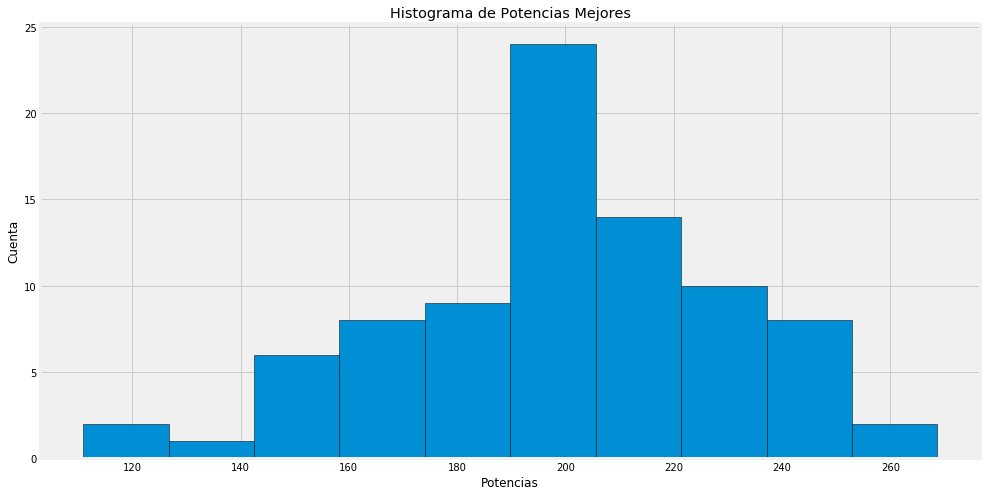

In [17]:
plt.figure(figsize = (15,8))
plt.hist(df_ganador['Potencia'], edgecolor ='k')
plt.title('Histograma de Potencias Mejores')
plt.xlabel('Potencias')
plt.ylabel('Cuenta')
plt.show()

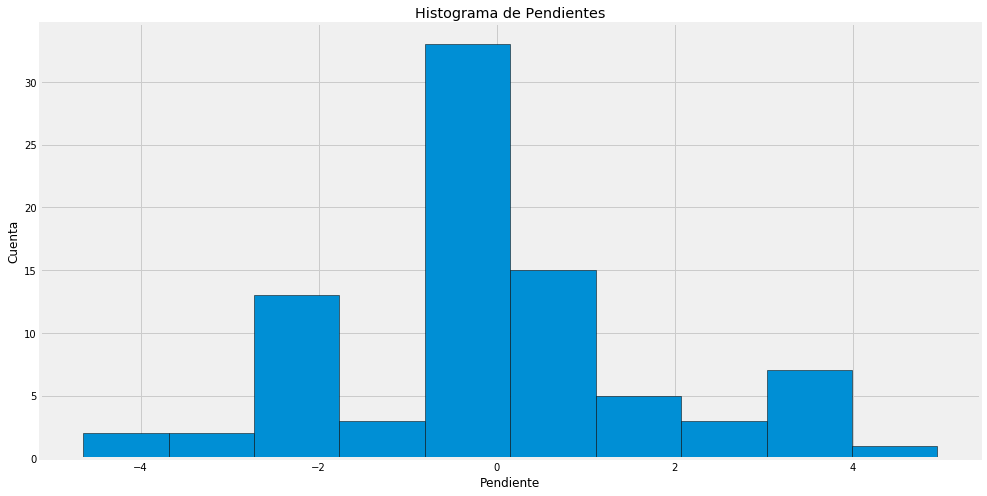

In [18]:
plt.figure(figsize = (15,8))
plt.hist(df_ganador['Pendiente'], edgecolor ='k')
plt.title('Histograma de Pendientes')
plt.xlabel('Pendiente')
plt.ylabel('Cuenta')
plt.show()

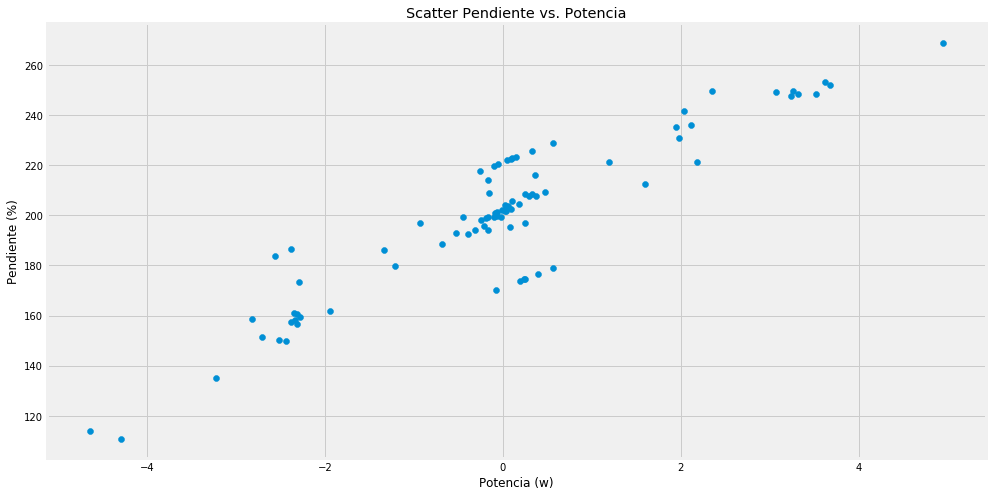

In [19]:
plt.figure(figsize = (15,8))
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])
plt.title('Scatter Pendiente vs. Potencia')
plt.xlabel('Potencia (w)')
plt.ylabel('Pendiente (%)')
plt.show()

La distribución de potencia es acorde a lo esperado. Vamos a ver como se comporta con respecto al viento

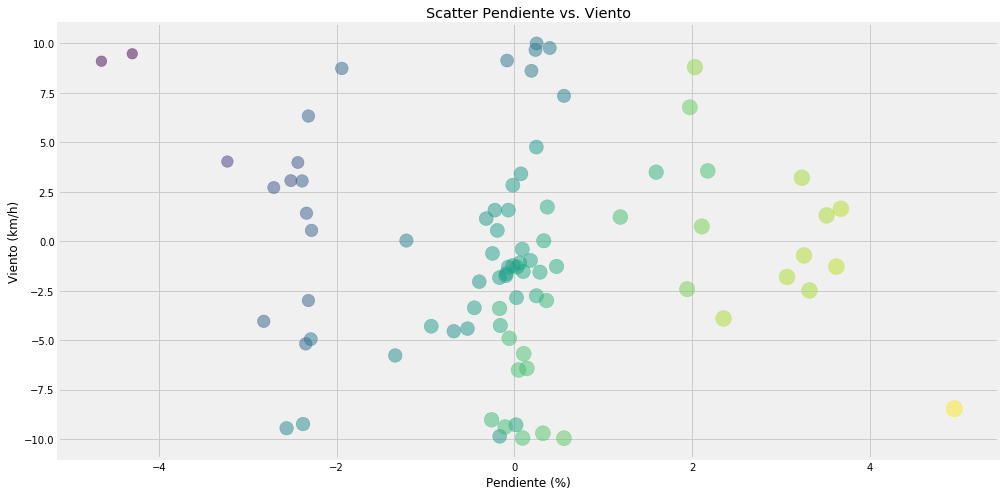

In [20]:
plt.figure(figsize = (15,8))
plt.scatter(df_ganador['Pendiente'],df_ganador['Viento'], c=df_ganador['Potencia'],s=df_ganador['Potencia'], alpha=0.5)
plt.title('Scatter Pendiente vs. Viento')
plt.xlabel('Pendiente (%)')
plt.ylabel('Viento (km/h)')
plt.show()

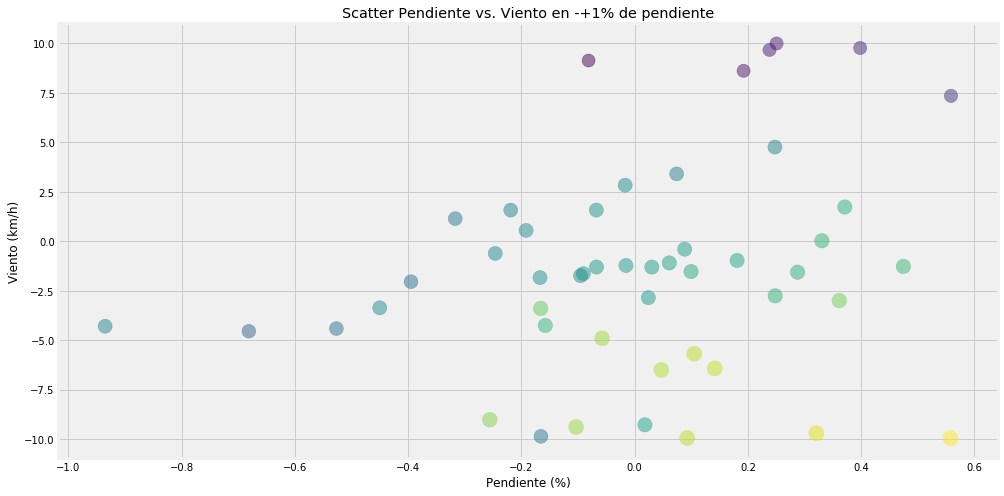

In [21]:
plt.figure(figsize = (15,8))
df_ganador_filtrado = df_ganador[(df_ganador['Pendiente']>-1) & (df_ganador['Pendiente']<1)]
plt.scatter(df_ganador_filtrado['Pendiente'].values,df_ganador_filtrado['Viento'].values, c=df_ganador_filtrado['Potencia'].values,
           s=df_ganador_filtrado['Potencia'].values, alpha=0.5)
plt.title('Scatter Pendiente vs. Viento en -+1% de pendiente')
plt.xlabel('Pendiente (%)')
plt.ylabel('Viento (km/h)')
plt.show()

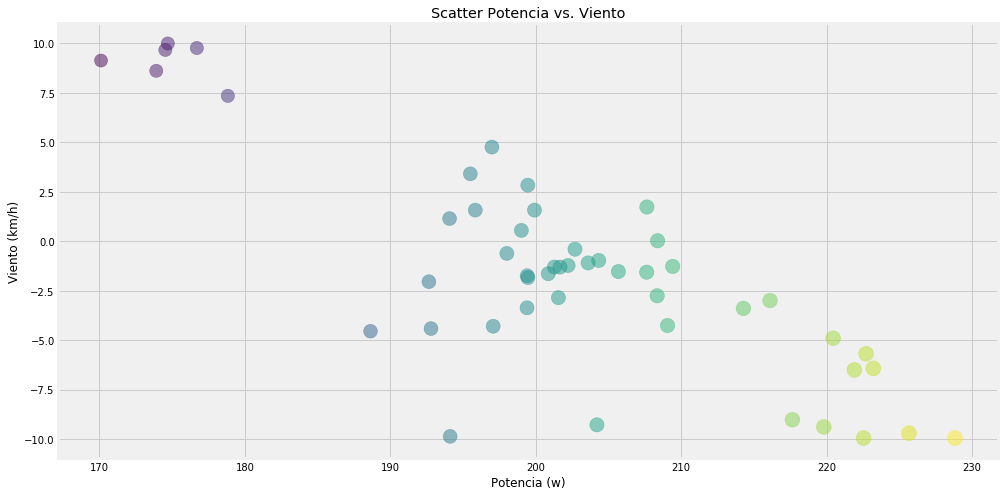

In [22]:
plt.figure(figsize = (15,8))
plt.scatter(df_ganador_filtrado['Potencia'].values,df_ganador_filtrado['Viento'].values, c=df_ganador_filtrado['Potencia'].values,
           s=df_ganador_filtrado['Potencia'].values, alpha=0.5)
plt.title('Scatter Potencia vs. Viento')
plt.xlabel('Potencia (w)')
plt.ylabel('Viento (km/h)')
plt.show()

Como podemos ver, la potencia aumenta según tenemos más viento a favor, lo cual es lógico si recordamos que el viento suma a la velocidad y se eleva al cuadrado

In [23]:
#Juntamos el resultado de la simulación con el recorrido original a efectos de comparativa posterior en Tableau
df_input = df[['tramo','pwr','spd','dist','time_seg','porc','viento_aparente']]
df_input.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
df_input['Intento'] = 'Original'
df_input.append([df_ganador]).to_excel('res_sim_ori.xlsx')
df_input.head()

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,0,0,344.041550,0,1.596116,3.492273,Original
1,1,0,0,13.567297,0,-0.218832,1.574548,Original
2,2,0,0,168.993513,0,0.371159,1.731397,Original
3,3,0,0,17.331806,0,-0.067596,1.575208,Original
4,4,0,0,48.498332,0,0.074144,3.407638,Original


In [44]:
potencias_medias = df_mejor.groupby(['Tramos'])['Potencia'].agg('mean')

#### Posible mejora del modelo, inicializando la potencia de cada tramo con el mejor resultado de la primera simulación

In [31]:
#CON TENSORFLOW (SEGUNDA PASADA)
#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Utilizamos los modelos que se emplearon en la primera pasada* es obviamente necesario ejecutar las celdas en orden
#model_TF = load_model('../RNN/TF_Tramos_2.model')
#model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 25 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Utilizamos las mismas constantes que se emplearon en la primera pasada* es obviamente necesario ejecutar las celdas en orden
#potencia_objetivo = 220
#pot_min = 60
#pot_max = 275
#ff_1 = 0.3
#ff_2 = 0.7

print("Tiempo a mejorar: %d" %mejor_tiempo)

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d, llevamos %d exitos y %d fracasos' %(fi,exito,fail))
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    bins_potencias = [0] * 30
    
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/4)-1
            max_random = abs(viento*3)+1
        else:
            max_random = (viento/4)+1
            min_random = (-1*viento*3)-1
        
        
        potencia_aux = potencias_medias[i]*(np.random.randint(min_random,max_random)+100)/100
        
        #Con el objetivo de complemplar mayor espectro, abrimos los intervalos 5w para probar
        potencia_min = pot_min+(pot_max-50-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))-5
        potencia_max = pot_min+50+(pot_max-pot_min-50)/(1+ff_1*np.e**(ff_2*porc*-1))+5

        
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
    
        #print(pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1)),potencias_medias[i], potencia)
        #input("sigue")

        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        #acumulamos el tiempo que se pasa en cada agrupacion de potencias
        bins_potencias[int(potencia/10)] =bins_potencias[int(potencia/10)] + nuevo_tiempo[0]
        
        i += 1
    
    
    
    potencia_media = potencia_acum/tiempo_acum
    
        #Marcamos las salidas con dos digitos
    #0  exito
    #XX1 Fuera de umbral de tolerancia
    #X1X Mas de 20min en zona de alta potencia (Criterio de negocio)
    #1XX No mejoramos tiempo de referencia
    
    
    salida = 0
    if (potencia_media < potencia_objetivo-5) or (potencia_media > potencia_objetivo+5):
        salida = salida+1
    if sum(bins_potencias[-5:])>1200:
        salida = salida+10
    if tiempo_acum[0]>mejor_tiempo:
        salida = salida+100

       
    print("Intento %d con potencia media %d, tiempo %d y salida %d" %(fi, potencia_media, tiempo_acum, salida))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5) and sum(bins_potencias[-5:])<1200 and tiempo_acum[0]<mejor_tiempo:
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

Tiempo a mejorar: 5111
Empezamos la prueba 0, llevamos 0 exitos y 0 fracasos
--- 0.0009887218475341797 seconds ---
Intento 0 con potencia media 209, tiempo 5148 y salida 100
Intento 1 con potencia media 209, tiempo 5147 y salida 100
Intento 2 con potencia media 210, tiempo 5132 y salida 110
Intento 3 con potencia media 212, tiempo 5105 y salida 10
Intento 4 con potencia media 210, tiempo 5122 y salida 110
Intento 5 con potencia media 209, tiempo 5136 y salida 100
Intento 6 con potencia media 210, tiempo 5122 y salida 110
Intento 7 con potencia media 211, tiempo 5122 y salida 110
Intento 8 con potencia media 211, tiempo 5128 y salida 110
Intento 9 con potencia media 211, tiempo 5123 y salida 100
Empezamos la prueba 10, llevamos 0 exitos y 10 fracasos
--- 0.9389901161193848 seconds ---
Intento 10 con potencia media 210, tiempo 5140 y salida 100
Intento 11 con potencia media 211, tiempo 5133 y salida 100
Intento 12 con potencia media 209, tiempo 5142 y salida 100
Intento 13 con potencia m

Intento 118 con potencia media 212, tiempo 5115 y salida 110
Intento 119 con potencia media 209, tiempo 5136 y salida 110
Empezamos la prueba 120, llevamos 0 exitos y 120 fracasos
--- 11.631081104278564 seconds ---
Intento 120 con potencia media 208, tiempo 5151 y salida 100
Intento 121 con potencia media 212, tiempo 5117 y salida 110
Intento 122 con potencia media 210, tiempo 5124 y salida 110
Intento 123 con potencia media 210, tiempo 5133 y salida 100
Intento 124 con potencia media 209, tiempo 5139 y salida 110
Intento 125 con potencia media 211, tiempo 5120 y salida 110
Intento 126 con potencia media 210, tiempo 5123 y salida 110
Intento 127 con potencia media 212, tiempo 5110 y salida 10
Intento 128 con potencia media 210, tiempo 5129 y salida 100
Intento 129 con potencia media 209, tiempo 5140 y salida 110
Empezamos la prueba 130, llevamos 0 exitos y 130 fracasos
--- 12.7484872341156 seconds ---
Intento 130 con potencia media 210, tiempo 5131 y salida 110
Intento 131 con potencia

Intento 237 con potencia media 210, tiempo 5128 y salida 100
Intento 238 con potencia media 211, tiempo 5113 y salida 100
Intento 239 con potencia media 210, tiempo 5127 y salida 100
Empezamos la prueba 240, llevamos 0 exitos y 240 fracasos
--- 23.5636785030365 seconds ---
Intento 240 con potencia media 209, tiempo 5137 y salida 100
Intento 241 con potencia media 212, tiempo 5107 y salida 10
Intento 242 con potencia media 208, tiempo 5146 y salida 110
Intento 243 con potencia media 210, tiempo 5120 y salida 110
Intento 244 con potencia media 210, tiempo 5136 y salida 110
Intento 245 con potencia media 209, tiempo 5144 y salida 100
Intento 246 con potencia media 211, tiempo 5118 y salida 110
Intento 247 con potencia media 210, tiempo 5141 y salida 100
Intento 248 con potencia media 210, tiempo 5127 y salida 100
Intento 249 con potencia media 209, tiempo 5134 y salida 110
Empezamos la prueba 250, llevamos 0 exitos y 250 fracasos
--- 24.504642486572266 seconds ---
Intento 250 con potencia

Intento 354 con potencia media 211, tiempo 5126 y salida 110
Intento 355 con potencia media 211, tiempo 5107 y salida 10
Intento 356 con potencia media 209, tiempo 5140 y salida 110
Intento 357 con potencia media 211, tiempo 5124 y salida 100
Intento 358 con potencia media 211, tiempo 5107 y salida 10
Intento 359 con potencia media 210, tiempo 5134 y salida 110
Empezamos la prueba 360, llevamos 0 exitos y 360 fracasos
--- 34.67830443382263 seconds ---
Intento 360 con potencia media 211, tiempo 5125 y salida 110
Intento 361 con potencia media 211, tiempo 5118 y salida 100
Intento 362 con potencia media 210, tiempo 5124 y salida 110
Intento 363 con potencia media 211, tiempo 5124 y salida 110
Intento 364 con potencia media 210, tiempo 5128 y salida 110
Intento 365 con potencia media 209, tiempo 5132 y salida 110
Intento 366 con potencia media 209, tiempo 5130 y salida 110
Intento 367 con potencia media 209, tiempo 5145 y salida 100
Intento 368 con potencia media 209, tiempo 5141 y salida

Intento 472 con potencia media 211, tiempo 5131 y salida 100
Intento 473 con potencia media 210, tiempo 5136 y salida 100
Intento 474 con potencia media 209, tiempo 5130 y salida 110
Intento 475 con potencia media 208, tiempo 5141 y salida 110
Intento 476 con potencia media 211, tiempo 5107 y salida 0
Intento 477 con potencia media 211, tiempo 5116 y salida 110
Intento 478 con potencia media 209, tiempo 5140 y salida 100
Intento 479 con potencia media 210, tiempo 5120 y salida 110
Empezamos la prueba 480, llevamos 1 exitos y 479 fracasos
--- 47.238845348358154 seconds ---
Intento 480 con potencia media 210, tiempo 5124 y salida 110
Intento 481 con potencia media 210, tiempo 5127 y salida 110
Intento 482 con potencia media 210, tiempo 5134 y salida 110
Intento 483 con potencia media 210, tiempo 5141 y salida 110
Intento 484 con potencia media 210, tiempo 5128 y salida 100
Intento 485 con potencia media 209, tiempo 5140 y salida 100
Intento 486 con potencia media 211, tiempo 5118 y salid

Intento 591 con potencia media 210, tiempo 5133 y salida 110
Intento 592 con potencia media 209, tiempo 5130 y salida 110
Intento 593 con potencia media 210, tiempo 5131 y salida 100
Intento 594 con potencia media 209, tiempo 5137 y salida 100
Intento 595 con potencia media 209, tiempo 5143 y salida 110
Intento 596 con potencia media 212, tiempo 5115 y salida 110
Intento 597 con potencia media 210, tiempo 5131 y salida 110
Intento 598 con potencia media 210, tiempo 5121 y salida 110
Intento 599 con potencia media 211, tiempo 5125 y salida 100
Empezamos la prueba 600, llevamos 1 exitos y 599 fracasos
--- 60.070714235305786 seconds ---
Intento 600 con potencia media 211, tiempo 5118 y salida 100
Intento 601 con potencia media 209, tiempo 5141 y salida 110
Intento 602 con potencia media 210, tiempo 5123 y salida 100
Intento 603 con potencia media 210, tiempo 5150 y salida 100
Intento 604 con potencia media 209, tiempo 5143 y salida 100
Intento 605 con potencia media 209, tiempo 5153 y sal

Intento 709 con potencia media 210, tiempo 5124 y salida 100
Empezamos la prueba 710, llevamos 2 exitos y 708 fracasos
--- 71.34649801254272 seconds ---
Intento 710 con potencia media 210, tiempo 5122 y salida 100
Intento 711 con potencia media 208, tiempo 5156 y salida 100
Intento 712 con potencia media 210, tiempo 5126 y salida 100
Intento 713 con potencia media 211, tiempo 5118 y salida 110
Intento 714 con potencia media 211, tiempo 5120 y salida 110
Intento 715 con potencia media 211, tiempo 5126 y salida 110
Intento 716 con potencia media 210, tiempo 5127 y salida 110
Intento 717 con potencia media 208, tiempo 5140 y salida 100
Intento 718 con potencia media 209, tiempo 5135 y salida 110
Intento 719 con potencia media 210, tiempo 5125 y salida 110
Empezamos la prueba 720, llevamos 2 exitos y 718 fracasos
--- 72.5339674949646 seconds ---
Intento 720 con potencia media 210, tiempo 5130 y salida 110
Intento 721 con potencia media 210, tiempo 5127 y salida 100
Intento 722 con potencia

Intento 826 con potencia media 212, tiempo 5110 y salida 10
Intento 827 con potencia media 210, tiempo 5126 y salida 100
Intento 828 con potencia media 211, tiempo 5111 y salida 100
Intento 829 con potencia media 209, tiempo 5136 y salida 110
Empezamos la prueba 830, llevamos 2 exitos y 828 fracasos
--- 83.67824840545654 seconds ---
Intento 830 con potencia media 209, tiempo 5139 y salida 110
Intento 831 con potencia media 211, tiempo 5120 y salida 110
Intento 832 con potencia media 210, tiempo 5133 y salida 100
Intento 833 con potencia media 210, tiempo 5128 y salida 100
Intento 834 con potencia media 211, tiempo 5113 y salida 110
Intento 835 con potencia media 211, tiempo 5120 y salida 110
Intento 836 con potencia media 210, tiempo 5131 y salida 110
Intento 837 con potencia media 209, tiempo 5151 y salida 100
Intento 838 con potencia media 211, tiempo 5117 y salida 100
Intento 839 con potencia media 211, tiempo 5125 y salida 110
Empezamos la prueba 840, llevamos 2 exitos y 838 fracas

Intento 945 con potencia media 210, tiempo 5128 y salida 100
Intento 946 con potencia media 209, tiempo 5132 y salida 110
Intento 947 con potencia media 210, tiempo 5134 y salida 110
Intento 948 con potencia media 211, tiempo 5121 y salida 100
Intento 949 con potencia media 211, tiempo 5127 y salida 110
Empezamos la prueba 950, llevamos 2 exitos y 948 fracasos
--- 95.63022947311401 seconds ---
Intento 950 con potencia media 209, tiempo 5129 y salida 110
Intento 951 con potencia media 209, tiempo 5141 y salida 100
Intento 952 con potencia media 211, tiempo 5108 y salida 10
Intento 953 con potencia media 210, tiempo 5124 y salida 110
Intento 954 con potencia media 209, tiempo 5144 y salida 110
Intento 955 con potencia media 209, tiempo 5132 y salida 110
Intento 956 con potencia media 209, tiempo 5142 y salida 100
Intento 957 con potencia media 207, tiempo 5147 y salida 100
Intento 958 con potencia media 210, tiempo 5139 y salida 100
Intento 959 con potencia media 210, tiempo 5129 y salid

Intento 1060 con potencia media 210, tiempo 5120 y salida 110
Intento 1061 con potencia media 210, tiempo 5133 y salida 100
Intento 1062 con potencia media 211, tiempo 5129 y salida 100
Intento 1063 con potencia media 208, tiempo 5146 y salida 100
Intento 1064 con potencia media 209, tiempo 5151 y salida 100
Intento 1065 con potencia media 211, tiempo 5117 y salida 110
Intento 1066 con potencia media 209, tiempo 5147 y salida 100
Intento 1067 con potencia media 210, tiempo 5122 y salida 110
Intento 1068 con potencia media 210, tiempo 5133 y salida 100
Intento 1069 con potencia media 211, tiempo 5127 y salida 110
Empezamos la prueba 1070, llevamos 2 exitos y 1068 fracasos
--- 108.53858804702759 seconds ---
Intento 1070 con potencia media 211, tiempo 5117 y salida 110
Intento 1071 con potencia media 211, tiempo 5130 y salida 110
Intento 1072 con potencia media 210, tiempo 5137 y salida 100
Intento 1073 con potencia media 210, tiempo 5126 y salida 110
Intento 1074 con potencia media 210, 

Intento 1177 con potencia media 211, tiempo 5120 y salida 110
Intento 1178 con potencia media 210, tiempo 5139 y salida 110
Intento 1179 con potencia media 212, tiempo 5111 y salida 110
Empezamos la prueba 1180, llevamos 3 exitos y 1177 fracasos
--- 120.60267543792725 seconds ---
Intento 1180 con potencia media 210, tiempo 5138 y salida 100
Intento 1181 con potencia media 209, tiempo 5144 y salida 100
Intento 1182 con potencia media 211, tiempo 5116 y salida 110
Intento 1183 con potencia media 210, tiempo 5123 y salida 110
Intento 1184 con potencia media 209, tiempo 5139 y salida 110
Intento 1185 con potencia media 210, tiempo 5134 y salida 100
Intento 1186 con potencia media 211, tiempo 5111 y salida 110
Intento 1187 con potencia media 207, tiempo 5172 y salida 100
Intento 1188 con potencia media 209, tiempo 5133 y salida 110
Intento 1189 con potencia media 210, tiempo 5129 y salida 110
Empezamos la prueba 1190, llevamos 3 exitos y 1187 fracasos
--- 121.54297709465027 seconds ---
Inte

Intento 1292 con potencia media 209, tiempo 5136 y salida 110
Intento 1293 con potencia media 210, tiempo 5130 y salida 110
Intento 1294 con potencia media 212, tiempo 5118 y salida 110
Intento 1295 con potencia media 212, tiempo 5111 y salida 110
Intento 1296 con potencia media 210, tiempo 5133 y salida 110
Intento 1297 con potencia media 209, tiempo 5133 y salida 100
Intento 1298 con potencia media 209, tiempo 5143 y salida 110
Intento 1299 con potencia media 211, tiempo 5115 y salida 110
Empezamos la prueba 1300, llevamos 3 exitos y 1297 fracasos
--- 132.013986825943 seconds ---
Intento 1300 con potencia media 211, tiempo 5116 y salida 110
Intento 1301 con potencia media 211, tiempo 5124 y salida 110
Intento 1302 con potencia media 210, tiempo 5129 y salida 100
Intento 1303 con potencia media 209, tiempo 5135 y salida 110
Intento 1304 con potencia media 211, tiempo 5121 y salida 100
Intento 1305 con potencia media 210, tiempo 5136 y salida 100
Intento 1306 con potencia media 209, ti

Intento 1408 con potencia media 210, tiempo 5142 y salida 110
Intento 1409 con potencia media 210, tiempo 5134 y salida 100
Empezamos la prueba 1410, llevamos 4 exitos y 1406 fracasos
--- 143.17739176750183 seconds ---
Intento 1410 con potencia media 208, tiempo 5144 y salida 100
Intento 1411 con potencia media 211, tiempo 5124 y salida 100
Intento 1412 con potencia media 210, tiempo 5128 y salida 100
Intento 1413 con potencia media 212, tiempo 5112 y salida 110
Intento 1414 con potencia media 210, tiempo 5131 y salida 100
Intento 1415 con potencia media 209, tiempo 5146 y salida 110
Intento 1416 con potencia media 210, tiempo 5137 y salida 100
Intento 1417 con potencia media 209, tiempo 5137 y salida 100
Intento 1418 con potencia media 210, tiempo 5126 y salida 100
Intento 1419 con potencia media 210, tiempo 5120 y salida 110
Empezamos la prueba 1420, llevamos 4 exitos y 1416 fracasos
--- 144.18116211891174 seconds ---
Intento 1420 con potencia media 210, tiempo 5131 y salida 100
Inte

Intento 1523 con potencia media 210, tiempo 5132 y salida 110
Intento 1524 con potencia media 211, tiempo 5119 y salida 100
Intento 1525 con potencia media 209, tiempo 5145 y salida 110
Intento 1526 con potencia media 210, tiempo 5132 y salida 100
Intento 1527 con potencia media 210, tiempo 5128 y salida 110
Intento 1528 con potencia media 210, tiempo 5121 y salida 110
Intento 1529 con potencia media 209, tiempo 5135 y salida 100
Empezamos la prueba 1530, llevamos 4 exitos y 1526 fracasos
--- 155.58166456222534 seconds ---
Intento 1530 con potencia media 211, tiempo 5119 y salida 110
Intento 1531 con potencia media 209, tiempo 5150 y salida 110
Intento 1532 con potencia media 210, tiempo 5125 y salida 100
Intento 1533 con potencia media 209, tiempo 5142 y salida 110
Intento 1534 con potencia media 209, tiempo 5143 y salida 100
Intento 1535 con potencia media 210, tiempo 5133 y salida 110
Intento 1536 con potencia media 211, tiempo 5120 y salida 110
Intento 1537 con potencia media 209, 

Intento 1641 con potencia media 210, tiempo 5130 y salida 110
Intento 1642 con potencia media 210, tiempo 5119 y salida 110
Intento 1643 con potencia media 210, tiempo 5118 y salida 110
Intento 1644 con potencia media 208, tiempo 5151 y salida 110
Intento 1645 con potencia media 211, tiempo 5121 y salida 110
Intento 1646 con potencia media 210, tiempo 5149 y salida 110
Intento 1647 con potencia media 210, tiempo 5132 y salida 110
Intento 1648 con potencia media 210, tiempo 5133 y salida 110
Intento 1649 con potencia media 210, tiempo 5139 y salida 100
Empezamos la prueba 1650, llevamos 4 exitos y 1646 fracasos
--- 167.81948685646057 seconds ---
Intento 1650 con potencia media 212, tiempo 5104 y salida 10
Intento 1651 con potencia media 211, tiempo 5128 y salida 110
Intento 1652 con potencia media 209, tiempo 5142 y salida 100
Intento 1653 con potencia media 210, tiempo 5124 y salida 110
Intento 1654 con potencia media 210, tiempo 5140 y salida 110
Intento 1655 con potencia media 210, t

Intento 1758 con potencia media 211, tiempo 5119 y salida 110
Intento 1759 con potencia media 210, tiempo 5124 y salida 110
Empezamos la prueba 1760, llevamos 4 exitos y 1756 fracasos
--- 178.71879720687866 seconds ---
Intento 1760 con potencia media 209, tiempo 5141 y salida 110
Intento 1761 con potencia media 211, tiempo 5127 y salida 110
Intento 1762 con potencia media 209, tiempo 5131 y salida 110
Intento 1763 con potencia media 210, tiempo 5127 y salida 100
Intento 1764 con potencia media 210, tiempo 5134 y salida 110
Intento 1765 con potencia media 210, tiempo 5124 y salida 110
Intento 1766 con potencia media 211, tiempo 5118 y salida 110
Intento 1767 con potencia media 209, tiempo 5133 y salida 110
Intento 1768 con potencia media 212, tiempo 5110 y salida 10
Intento 1769 con potencia media 209, tiempo 5143 y salida 100
Empezamos la prueba 1770, llevamos 4 exitos y 1766 fracasos
--- 179.70034623146057 seconds ---
Intento 1770 con potencia media 211, tiempo 5120 y salida 100
Inten

Intento 1874 con potencia media 210, tiempo 5129 y salida 100
Intento 1875 con potencia media 209, tiempo 5130 y salida 100
Intento 1876 con potencia media 211, tiempo 5122 y salida 100
Intento 1877 con potencia media 211, tiempo 5119 y salida 110
Intento 1878 con potencia media 210, tiempo 5124 y salida 110
Intento 1879 con potencia media 210, tiempo 5128 y salida 100
Empezamos la prueba 1880, llevamos 5 exitos y 1875 fracasos
--- 190.21879959106445 seconds ---
Intento 1880 con potencia media 210, tiempo 5138 y salida 100
Intento 1881 con potencia media 210, tiempo 5124 y salida 110
Intento 1882 con potencia media 210, tiempo 5127 y salida 110
Intento 1883 con potencia media 210, tiempo 5135 y salida 100
Intento 1884 con potencia media 210, tiempo 5137 y salida 100
Intento 1885 con potencia media 210, tiempo 5133 y salida 100
Intento 1886 con potencia media 209, tiempo 5145 y salida 100
Intento 1887 con potencia media 210, tiempo 5125 y salida 110
Intento 1888 con potencia media 209, 

Intento 1991 con potencia media 211, tiempo 5120 y salida 110
Intento 1992 con potencia media 209, tiempo 5149 y salida 110
Intento 1993 con potencia media 211, tiempo 5119 y salida 100
Intento 1994 con potencia media 208, tiempo 5149 y salida 100
Intento 1995 con potencia media 210, tiempo 5127 y salida 100
Intento 1996 con potencia media 209, tiempo 5149 y salida 110
Intento 1997 con potencia media 208, tiempo 5155 y salida 100
Intento 1998 con potencia media 212, tiempo 5118 y salida 110
Intento 1999 con potencia media 211, tiempo 5116 y salida 110
Empezamos la prueba 2000, llevamos 7 exitos y 1993 fracasos
--- 201.58416652679443 seconds ---
Intento 2000 con potencia media 208, tiempo 5150 y salida 100
Intento 2001 con potencia media 209, tiempo 5134 y salida 100
Intento 2002 con potencia media 211, tiempo 5129 y salida 110
Intento 2003 con potencia media 210, tiempo 5128 y salida 110
Intento 2004 con potencia media 208, tiempo 5145 y salida 110
Intento 2005 con potencia media 211, 

Intento 2108 con potencia media 209, tiempo 5143 y salida 100
Intento 2109 con potencia media 210, tiempo 5125 y salida 110
Empezamos la prueba 2110, llevamos 9 exitos y 2101 fracasos
--- 212.3943419456482 seconds ---
Intento 2110 con potencia media 209, tiempo 5146 y salida 100
Intento 2111 con potencia media 210, tiempo 5142 y salida 100
Intento 2112 con potencia media 209, tiempo 5132 y salida 100
Intento 2113 con potencia media 210, tiempo 5124 y salida 110
Intento 2114 con potencia media 210, tiempo 5138 y salida 100
Intento 2115 con potencia media 209, tiempo 5135 y salida 110
Intento 2116 con potencia media 211, tiempo 5112 y salida 110
Intento 2117 con potencia media 211, tiempo 5131 y salida 100
Intento 2118 con potencia media 210, tiempo 5119 y salida 110
Intento 2119 con potencia media 209, tiempo 5138 y salida 100
Empezamos la prueba 2120, llevamos 9 exitos y 2111 fracasos
--- 213.3985948562622 seconds ---
Intento 2120 con potencia media 210, tiempo 5136 y salida 110
Intent

Intento 2222 con potencia media 211, tiempo 5133 y salida 110
Intento 2223 con potencia media 210, tiempo 5133 y salida 100
Intento 2224 con potencia media 210, tiempo 5130 y salida 110
Intento 2225 con potencia media 209, tiempo 5144 y salida 100
Intento 2226 con potencia media 210, tiempo 5135 y salida 100
Intento 2227 con potencia media 210, tiempo 5117 y salida 110
Intento 2228 con potencia media 211, tiempo 5123 y salida 110
Intento 2229 con potencia media 211, tiempo 5121 y salida 110
Empezamos la prueba 2230, llevamos 9 exitos y 2221 fracasos
--- 224.10002422332764 seconds ---
Intento 2230 con potencia media 207, tiempo 5156 y salida 110
Intento 2231 con potencia media 209, tiempo 5144 y salida 100
Intento 2232 con potencia media 209, tiempo 5142 y salida 100
Intento 2233 con potencia media 210, tiempo 5130 y salida 110
Intento 2234 con potencia media 210, tiempo 5118 y salida 110
Intento 2235 con potencia media 210, tiempo 5146 y salida 100
Intento 2236 con potencia media 209, 

Intento 2339 con potencia media 210, tiempo 5130 y salida 110
Empezamos la prueba 2340, llevamos 9 exitos y 2331 fracasos
--- 234.81629586219788 seconds ---
Intento 2340 con potencia media 210, tiempo 5129 y salida 110
Intento 2341 con potencia media 209, tiempo 5142 y salida 100
Intento 2342 con potencia media 209, tiempo 5140 y salida 110
Intento 2343 con potencia media 211, tiempo 5114 y salida 110
Intento 2344 con potencia media 210, tiempo 5133 y salida 110
Intento 2345 con potencia media 210, tiempo 5132 y salida 110
Intento 2346 con potencia media 212, tiempo 5118 y salida 100
Intento 2347 con potencia media 211, tiempo 5126 y salida 110
Intento 2348 con potencia media 211, tiempo 5116 y salida 110
Intento 2349 con potencia media 211, tiempo 5121 y salida 110
Empezamos la prueba 2350, llevamos 9 exitos y 2341 fracasos
--- 235.77653169631958 seconds ---
Intento 2350 con potencia media 208, tiempo 5143 y salida 110
Intento 2351 con potencia media 210, tiempo 5132 y salida 110
Inte

Intento 2454 con potencia media 211, tiempo 5129 y salida 100
Intento 2455 con potencia media 211, tiempo 5124 y salida 110
Intento 2456 con potencia media 209, tiempo 5135 y salida 110
Intento 2457 con potencia media 208, tiempo 5149 y salida 110
Intento 2458 con potencia media 211, tiempo 5116 y salida 110
Intento 2459 con potencia media 209, tiempo 5135 y salida 110
Empezamos la prueba 2460, llevamos 10 exitos y 2450 fracasos
--- 246.74766445159912 seconds ---
Intento 2460 con potencia media 209, tiempo 5140 y salida 100
Intento 2461 con potencia media 210, tiempo 5129 y salida 110
Intento 2462 con potencia media 210, tiempo 5122 y salida 110
Intento 2463 con potencia media 209, tiempo 5137 y salida 110
Intento 2464 con potencia media 210, tiempo 5126 y salida 110
Intento 2465 con potencia media 211, tiempo 5112 y salida 110
Intento 2466 con potencia media 210, tiempo 5128 y salida 110
Intento 2467 con potencia media 209, tiempo 5145 y salida 100
Intento 2468 con potencia media 209,

Intento 2570 con potencia media 211, tiempo 5119 y salida 110
Intento 2571 con potencia media 209, tiempo 5143 y salida 100
Intento 2572 con potencia media 209, tiempo 5145 y salida 100
Intento 2573 con potencia media 210, tiempo 5125 y salida 110
Intento 2574 con potencia media 210, tiempo 5136 y salida 110
Intento 2575 con potencia media 210, tiempo 5130 y salida 110
Intento 2576 con potencia media 209, tiempo 5142 y salida 100
Intento 2577 con potencia media 211, tiempo 5120 y salida 110
Intento 2578 con potencia media 208, tiempo 5150 y salida 100
Intento 2579 con potencia media 211, tiempo 5127 y salida 110
Empezamos la prueba 2580, llevamos 11 exitos y 2569 fracasos
--- 258.7559883594513 seconds ---
Intento 2580 con potencia media 209, tiempo 5140 y salida 110
Intento 2581 con potencia media 210, tiempo 5127 y salida 100
Intento 2582 con potencia media 212, tiempo 5113 y salida 100
Intento 2583 con potencia media 209, tiempo 5138 y salida 100
Intento 2584 con potencia media 210, 

Intento 2686 con potencia media 211, tiempo 5119 y salida 110
Intento 2687 con potencia media 211, tiempo 5115 y salida 110
Intento 2688 con potencia media 211, tiempo 5116 y salida 100
Intento 2689 con potencia media 208, tiempo 5152 y salida 100
Empezamos la prueba 2690, llevamos 12 exitos y 2678 fracasos
--- 269.0673711299896 seconds ---
Intento 2690 con potencia media 210, tiempo 5121 y salida 100
Intento 2691 con potencia media 211, tiempo 5117 y salida 110
Intento 2692 con potencia media 210, tiempo 5136 y salida 110
Intento 2693 con potencia media 209, tiempo 5157 y salida 100
Intento 2694 con potencia media 210, tiempo 5138 y salida 110
Intento 2695 con potencia media 211, tiempo 5121 y salida 110
Intento 2696 con potencia media 208, tiempo 5142 y salida 100
Intento 2697 con potencia media 210, tiempo 5131 y salida 110
Intento 2698 con potencia media 211, tiempo 5125 y salida 100
Intento 2699 con potencia media 210, tiempo 5124 y salida 110
Empezamos la prueba 2700, llevamos 12

Intento 2800 con potencia media 211, tiempo 5127 y salida 110
Intento 2801 con potencia media 211, tiempo 5123 y salida 100
Intento 2802 con potencia media 212, tiempo 5115 y salida 110
Intento 2803 con potencia media 209, tiempo 5134 y salida 110
Intento 2804 con potencia media 210, tiempo 5120 y salida 110
Intento 2805 con potencia media 210, tiempo 5128 y salida 110
Intento 2806 con potencia media 210, tiempo 5128 y salida 100
Intento 2807 con potencia media 210, tiempo 5130 y salida 100
Intento 2808 con potencia media 209, tiempo 5140 y salida 100
Intento 2809 con potencia media 210, tiempo 5141 y salida 110
Empezamos la prueba 2810, llevamos 12 exitos y 2798 fracasos
--- 284.1881401538849 seconds ---
Intento 2810 con potencia media 211, tiempo 5124 y salida 110
Intento 2811 con potencia media 208, tiempo 5155 y salida 110
Intento 2812 con potencia media 211, tiempo 5115 y salida 100
Intento 2813 con potencia media 210, tiempo 5129 y salida 100
Intento 2814 con potencia media 211, 

Intento 2917 con potencia media 210, tiempo 5139 y salida 100
Intento 2918 con potencia media 210, tiempo 5137 y salida 110
Intento 2919 con potencia media 211, tiempo 5121 y salida 100
Empezamos la prueba 2920, llevamos 13 exitos y 2907 fracasos
--- 297.67941093444824 seconds ---
Intento 2920 con potencia media 210, tiempo 5131 y salida 110
Intento 2921 con potencia media 210, tiempo 5134 y salida 110
Intento 2922 con potencia media 210, tiempo 5127 y salida 100
Intento 2923 con potencia media 211, tiempo 5112 y salida 110
Intento 2924 con potencia media 209, tiempo 5147 y salida 110
Intento 2925 con potencia media 208, tiempo 5143 y salida 100
Intento 2926 con potencia media 212, tiempo 5119 y salida 100
Intento 2927 con potencia media 210, tiempo 5146 y salida 100
Intento 2928 con potencia media 210, tiempo 5134 y salida 110
Intento 2929 con potencia media 210, tiempo 5129 y salida 110
Empezamos la prueba 2930, llevamos 13 exitos y 2917 fracasos
--- 298.66137886047363 seconds ---
In

Intento 3033 con potencia media 210, tiempo 5126 y salida 100
Intento 3034 con potencia media 209, tiempo 5128 y salida 100
Intento 3035 con potencia media 211, tiempo 5125 y salida 100
Intento 3036 con potencia media 212, tiempo 5117 y salida 110
Intento 3037 con potencia media 211, tiempo 5136 y salida 100
Intento 3038 con potencia media 211, tiempo 5117 y salida 110
Intento 3039 con potencia media 212, tiempo 5109 y salida 10
Empezamos la prueba 3040, llevamos 13 exitos y 3027 fracasos
--- 309.4356687068939 seconds ---
Intento 3040 con potencia media 210, tiempo 5129 y salida 100
Intento 3041 con potencia media 210, tiempo 5121 y salida 100
Intento 3042 con potencia media 209, tiempo 5141 y salida 110
Intento 3043 con potencia media 211, tiempo 5116 y salida 110
Intento 3044 con potencia media 210, tiempo 5141 y salida 110
Intento 3045 con potencia media 210, tiempo 5125 y salida 100
Intento 3046 con potencia media 209, tiempo 5139 y salida 100
Intento 3047 con potencia media 210, t

Intento 3150 con potencia media 209, tiempo 5147 y salida 100
Intento 3151 con potencia media 211, tiempo 5120 y salida 100
Intento 3152 con potencia media 210, tiempo 5136 y salida 100
Intento 3153 con potencia media 211, tiempo 5123 y salida 110
Intento 3154 con potencia media 211, tiempo 5114 y salida 110
Intento 3155 con potencia media 209, tiempo 5134 y salida 110
Intento 3156 con potencia media 211, tiempo 5120 y salida 100
Intento 3157 con potencia media 210, tiempo 5140 y salida 100
Intento 3158 con potencia media 209, tiempo 5158 y salida 100
Intento 3159 con potencia media 210, tiempo 5136 y salida 110
Empezamos la prueba 3160, llevamos 13 exitos y 3147 fracasos
--- 327.7389175891876 seconds ---
Intento 3160 con potencia media 210, tiempo 5121 y salida 100
Intento 3161 con potencia media 210, tiempo 5129 y salida 110
Intento 3162 con potencia media 212, tiempo 5112 y salida 110
Intento 3163 con potencia media 208, tiempo 5160 y salida 100
Intento 3164 con potencia media 210, 

Intento 3266 con potencia media 209, tiempo 5138 y salida 110
Intento 3267 con potencia media 210, tiempo 5129 y salida 100
Intento 3268 con potencia media 212, tiempo 5109 y salida 10
Intento 3269 con potencia media 209, tiempo 5152 y salida 100
Empezamos la prueba 3270, llevamos 13 exitos y 3257 fracasos
--- 346.25653886795044 seconds ---
Intento 3270 con potencia media 209, tiempo 5141 y salida 110
Intento 3271 con potencia media 209, tiempo 5148 y salida 100
Intento 3272 con potencia media 210, tiempo 5123 y salida 110
Intento 3273 con potencia media 211, tiempo 5127 y salida 110
Intento 3274 con potencia media 210, tiempo 5137 y salida 110
Intento 3275 con potencia media 208, tiempo 5147 y salida 110
Intento 3276 con potencia media 208, tiempo 5146 y salida 110
Intento 3277 con potencia media 210, tiempo 5129 y salida 100
Intento 3278 con potencia media 210, tiempo 5122 y salida 110
Intento 3279 con potencia media 211, tiempo 5117 y salida 110
Empezamos la prueba 3280, llevamos 13

Intento 3381 con potencia media 210, tiempo 5132 y salida 100
Intento 3382 con potencia media 210, tiempo 5140 y salida 100
Intento 3383 con potencia media 211, tiempo 5128 y salida 110
Intento 3384 con potencia media 212, tiempo 5114 y salida 110
Intento 3385 con potencia media 209, tiempo 5138 y salida 100
Intento 3386 con potencia media 212, tiempo 5116 y salida 110
Intento 3387 con potencia media 210, tiempo 5125 y salida 100
Intento 3388 con potencia media 210, tiempo 5132 y salida 100
Intento 3389 con potencia media 211, tiempo 5111 y salida 110
Empezamos la prueba 3390, llevamos 13 exitos y 3377 fracasos
--- 367.6019961833954 seconds ---
Intento 3390 con potencia media 210, tiempo 5133 y salida 100
Intento 3391 con potencia media 208, tiempo 5144 y salida 100
Intento 3392 con potencia media 211, tiempo 5123 y salida 110
Intento 3393 con potencia media 210, tiempo 5125 y salida 110
Intento 3394 con potencia media 210, tiempo 5129 y salida 110
Intento 3395 con potencia media 210, 

Intento 3497 con potencia media 210, tiempo 5137 y salida 100
Intento 3498 con potencia media 210, tiempo 5128 y salida 110
Intento 3499 con potencia media 210, tiempo 5128 y salida 110
Empezamos la prueba 3500, llevamos 13 exitos y 3487 fracasos
--- 383.44365906715393 seconds ---
Intento 3500 con potencia media 208, tiempo 5148 y salida 100
Intento 3501 con potencia media 209, tiempo 5146 y salida 110
Intento 3502 con potencia media 208, tiempo 5150 y salida 100
Intento 3503 con potencia media 209, tiempo 5140 y salida 100
Intento 3504 con potencia media 212, tiempo 5106 y salida 10
Intento 3505 con potencia media 210, tiempo 5132 y salida 110
Intento 3506 con potencia media 212, tiempo 5120 y salida 100
Intento 3507 con potencia media 210, tiempo 5133 y salida 100
Intento 3508 con potencia media 209, tiempo 5143 y salida 100
Intento 3509 con potencia media 212, tiempo 5105 y salida 10
Empezamos la prueba 3510, llevamos 13 exitos y 3497 fracasos
--- 384.9047112464905 seconds ---
Inten

Intento 3611 con potencia media 210, tiempo 5132 y salida 100
Intento 3612 con potencia media 210, tiempo 5136 y salida 110
Intento 3613 con potencia media 210, tiempo 5124 y salida 110
Intento 3614 con potencia media 209, tiempo 5141 y salida 100
Intento 3615 con potencia media 210, tiempo 5129 y salida 100
Intento 3616 con potencia media 210, tiempo 5127 y salida 110
Intento 3617 con potencia media 210, tiempo 5139 y salida 110
Intento 3618 con potencia media 209, tiempo 5134 y salida 110
Intento 3619 con potencia media 211, tiempo 5121 y salida 110
Empezamos la prueba 3620, llevamos 13 exitos y 3607 fracasos
--- 397.31038093566895 seconds ---
Intento 3620 con potencia media 208, tiempo 5151 y salida 110
Intento 3621 con potencia media 209, tiempo 5141 y salida 110
Intento 3622 con potencia media 209, tiempo 5145 y salida 110
Intento 3623 con potencia media 211, tiempo 5138 y salida 110
Intento 3624 con potencia media 212, tiempo 5115 y salida 110
Intento 3625 con potencia media 212,

Intento 3728 con potencia media 211, tiempo 5119 y salida 110
Intento 3729 con potencia media 211, tiempo 5120 y salida 100
Empezamos la prueba 3730, llevamos 13 exitos y 3717 fracasos
--- 408.34820580482483 seconds ---
Intento 3730 con potencia media 210, tiempo 5130 y salida 100
Intento 3731 con potencia media 209, tiempo 5134 y salida 110
Intento 3732 con potencia media 209, tiempo 5133 y salida 110
Intento 3733 con potencia media 210, tiempo 5124 y salida 110
Intento 3734 con potencia media 209, tiempo 5132 y salida 100
Intento 3735 con potencia media 210, tiempo 5127 y salida 110
Intento 3736 con potencia media 211, tiempo 5113 y salida 110
Intento 3737 con potencia media 210, tiempo 5130 y salida 100
Intento 3738 con potencia media 210, tiempo 5131 y salida 110
Intento 3739 con potencia media 209, tiempo 5141 y salida 110
Empezamos la prueba 3740, llevamos 13 exitos y 3727 fracasos
--- 409.37064576148987 seconds ---
Intento 3740 con potencia media 211, tiempo 5116 y salida 110
In

Intento 3844 con potencia media 210, tiempo 5130 y salida 100
Intento 3845 con potencia media 212, tiempo 5112 y salida 110
Intento 3846 con potencia media 209, tiempo 5137 y salida 110
Intento 3847 con potencia media 212, tiempo 5121 y salida 110
Intento 3848 con potencia media 211, tiempo 5128 y salida 100
Intento 3849 con potencia media 210, tiempo 5124 y salida 100
Empezamos la prueba 3850, llevamos 13 exitos y 3837 fracasos
--- 420.1757357120514 seconds ---
Intento 3850 con potencia media 210, tiempo 5130 y salida 110
Intento 3851 con potencia media 212, tiempo 5105 y salida 10
Intento 3852 con potencia media 210, tiempo 5125 y salida 110
Intento 3853 con potencia media 212, tiempo 5118 y salida 110
Intento 3854 con potencia media 211, tiempo 5121 y salida 110
Intento 3855 con potencia media 209, tiempo 5142 y salida 110
Intento 3856 con potencia media 211, tiempo 5120 y salida 100
Intento 3857 con potencia media 209, tiempo 5147 y salida 100
Intento 3858 con potencia media 212, t

Intento 3961 con potencia media 210, tiempo 5141 y salida 100
Intento 3962 con potencia media 210, tiempo 5133 y salida 100
Intento 3963 con potencia media 210, tiempo 5129 y salida 100
Intento 3964 con potencia media 211, tiempo 5130 y salida 100
Intento 3965 con potencia media 209, tiempo 5131 y salida 110
Intento 3966 con potencia media 209, tiempo 5144 y salida 110
Intento 3967 con potencia media 211, tiempo 5125 y salida 100
Intento 3968 con potencia media 210, tiempo 5138 y salida 110
Intento 3969 con potencia media 210, tiempo 5132 y salida 110
Empezamos la prueba 3970, llevamos 14 exitos y 3956 fracasos
--- 432.3885087966919 seconds ---
Intento 3970 con potencia media 210, tiempo 5129 y salida 110
Intento 3971 con potencia media 208, tiempo 5150 y salida 110
Intento 3972 con potencia media 209, tiempo 5143 y salida 110
Intento 3973 con potencia media 210, tiempo 5125 y salida 110
Intento 3974 con potencia media 210, tiempo 5133 y salida 110
Intento 3975 con potencia media 209, 

Intento 4078 con potencia media 209, tiempo 5137 y salida 110
Intento 4079 con potencia media 212, tiempo 5110 y salida 10
Empezamos la prueba 4080, llevamos 14 exitos y 4066 fracasos
--- 443.7224485874176 seconds ---
Intento 4080 con potencia media 209, tiempo 5148 y salida 100
Intento 4081 con potencia media 210, tiempo 5119 y salida 100
Intento 4082 con potencia media 210, tiempo 5142 y salida 100
Intento 4083 con potencia media 210, tiempo 5136 y salida 100
Intento 4084 con potencia media 210, tiempo 5131 y salida 110
Intento 4085 con potencia media 211, tiempo 5117 y salida 110
Intento 4086 con potencia media 211, tiempo 5114 y salida 110
Intento 4087 con potencia media 210, tiempo 5138 y salida 100
Intento 4088 con potencia media 210, tiempo 5124 y salida 110
Intento 4089 con potencia media 212, tiempo 5111 y salida 10
Empezamos la prueba 4090, llevamos 14 exitos y 4076 fracasos
--- 444.75110816955566 seconds ---
Intento 4090 con potencia media 209, tiempo 5136 y salida 100
Inten

Intento 4193 con potencia media 210, tiempo 5131 y salida 110
Intento 4194 con potencia media 209, tiempo 5134 y salida 110
Intento 4195 con potencia media 208, tiempo 5153 y salida 100
Intento 4196 con potencia media 211, tiempo 5127 y salida 110
Intento 4197 con potencia media 212, tiempo 5105 y salida 10
Intento 4198 con potencia media 208, tiempo 5155 y salida 100
Intento 4199 con potencia media 211, tiempo 5124 y salida 110
Empezamos la prueba 4200, llevamos 14 exitos y 4186 fracasos
--- 456.19792652130127 seconds ---
Intento 4200 con potencia media 210, tiempo 5132 y salida 100
Intento 4201 con potencia media 211, tiempo 5130 y salida 110
Intento 4202 con potencia media 211, tiempo 5121 y salida 110
Intento 4203 con potencia media 209, tiempo 5140 y salida 100
Intento 4204 con potencia media 210, tiempo 5143 y salida 110
Intento 4205 con potencia media 208, tiempo 5149 y salida 100
Intento 4206 con potencia media 210, tiempo 5122 y salida 110
Intento 4207 con potencia media 210, 

Intento 4310 con potencia media 210, tiempo 5132 y salida 100
Intento 4311 con potencia media 209, tiempo 5138 y salida 110
Intento 4312 con potencia media 212, tiempo 5104 y salida 10
Intento 4313 con potencia media 209, tiempo 5137 y salida 100
Intento 4314 con potencia media 212, tiempo 5119 y salida 100
Intento 4315 con potencia media 209, tiempo 5137 y salida 100
Intento 4316 con potencia media 210, tiempo 5133 y salida 110
Intento 4317 con potencia media 210, tiempo 5136 y salida 110
Intento 4318 con potencia media 212, tiempo 5116 y salida 110
Intento 4319 con potencia media 210, tiempo 5141 y salida 100
Empezamos la prueba 4320, llevamos 14 exitos y 4306 fracasos
--- 468.4005904197693 seconds ---
Intento 4320 con potencia media 210, tiempo 5134 y salida 110
Intento 4321 con potencia media 210, tiempo 5126 y salida 100
Intento 4322 con potencia media 211, tiempo 5114 y salida 110
Intento 4323 con potencia media 209, tiempo 5142 y salida 110
Intento 4324 con potencia media 212, t

Intento 4427 con potencia media 211, tiempo 5135 y salida 110
Intento 4428 con potencia media 210, tiempo 5123 y salida 100
Intento 4429 con potencia media 210, tiempo 5141 y salida 100
Empezamos la prueba 4430, llevamos 14 exitos y 4416 fracasos
--- 479.6779794692993 seconds ---
Intento 4430 con potencia media 210, tiempo 5135 y salida 110
Intento 4431 con potencia media 208, tiempo 5146 y salida 100
Intento 4432 con potencia media 208, tiempo 5152 y salida 100
Intento 4433 con potencia media 209, tiempo 5137 y salida 100
Intento 4434 con potencia media 210, tiempo 5119 y salida 100
Intento 4435 con potencia media 212, tiempo 5116 y salida 110
Intento 4436 con potencia media 211, tiempo 5120 y salida 110
Intento 4437 con potencia media 210, tiempo 5131 y salida 100
Intento 4438 con potencia media 210, tiempo 5127 y salida 110
Intento 4439 con potencia media 209, tiempo 5144 y salida 100
Empezamos la prueba 4440, llevamos 14 exitos y 4426 fracasos
--- 480.76065254211426 seconds ---
Int

Intento 4542 con potencia media 208, tiempo 5134 y salida 110
Intento 4543 con potencia media 209, tiempo 5143 y salida 100
Intento 4544 con potencia media 210, tiempo 5133 y salida 110
Intento 4545 con potencia media 210, tiempo 5137 y salida 100
Intento 4546 con potencia media 208, tiempo 5157 y salida 100
Intento 4547 con potencia media 208, tiempo 5149 y salida 100
Intento 4548 con potencia media 211, tiempo 5114 y salida 110
Intento 4549 con potencia media 209, tiempo 5137 y salida 110
Empezamos la prueba 4550, llevamos 14 exitos y 4536 fracasos
--- 492.355801820755 seconds ---
Intento 4550 con potencia media 212, tiempo 5101 y salida 10
Intento 4551 con potencia media 211, tiempo 5125 y salida 110
Intento 4552 con potencia media 208, tiempo 5150 y salida 100
Intento 4553 con potencia media 211, tiempo 5121 y salida 110
Intento 4554 con potencia media 211, tiempo 5114 y salida 110
Intento 4555 con potencia media 209, tiempo 5149 y salida 100
Intento 4556 con potencia media 210, ti

Intento 4659 con potencia media 211, tiempo 5119 y salida 100
Empezamos la prueba 4660, llevamos 14 exitos y 4646 fracasos
--- 502.67823338508606 seconds ---
Intento 4660 con potencia media 211, tiempo 5114 y salida 110
Intento 4661 con potencia media 210, tiempo 5127 y salida 110
Intento 4662 con potencia media 210, tiempo 5123 y salida 100
Intento 4663 con potencia media 209, tiempo 5148 y salida 110
Intento 4664 con potencia media 209, tiempo 5135 y salida 110
Intento 4665 con potencia media 209, tiempo 5142 y salida 100
Intento 4666 con potencia media 210, tiempo 5144 y salida 100
Intento 4667 con potencia media 210, tiempo 5129 y salida 100
Intento 4668 con potencia media 211, tiempo 5118 y salida 100
Intento 4669 con potencia media 212, tiempo 5110 y salida 10
Empezamos la prueba 4670, llevamos 14 exitos y 4656 fracasos
--- 503.7079532146454 seconds ---
Intento 4670 con potencia media 210, tiempo 5137 y salida 100
Intento 4671 con potencia media 210, tiempo 5131 y salida 100
Inte

Intento 4774 con potencia media 211, tiempo 5112 y salida 110
Intento 4775 con potencia media 210, tiempo 5142 y salida 100
Intento 4776 con potencia media 209, tiempo 5143 y salida 110
Intento 4777 con potencia media 209, tiempo 5140 y salida 100
Intento 4778 con potencia media 209, tiempo 5126 y salida 100
Intento 4779 con potencia media 209, tiempo 5142 y salida 110
Empezamos la prueba 4780, llevamos 15 exitos y 4765 fracasos
--- 514.1237440109253 seconds ---
Intento 4780 con potencia media 210, tiempo 5129 y salida 100
Intento 4781 con potencia media 212, tiempo 5111 y salida 10
Intento 4782 con potencia media 210, tiempo 5130 y salida 110
Intento 4783 con potencia media 210, tiempo 5128 y salida 110
Intento 4784 con potencia media 211, tiempo 5132 y salida 100
Intento 4785 con potencia media 209, tiempo 5140 y salida 100
Intento 4786 con potencia media 210, tiempo 5121 y salida 110
Intento 4787 con potencia media 210, tiempo 5129 y salida 100
Intento 4788 con potencia media 210, t

Intento 4892 con potencia media 211, tiempo 5123 y salida 110
Intento 4893 con potencia media 209, tiempo 5139 y salida 110
Intento 4894 con potencia media 209, tiempo 5149 y salida 100
Intento 4895 con potencia media 211, tiempo 5111 y salida 10
Intento 4896 con potencia media 209, tiempo 5133 y salida 110
Intento 4897 con potencia media 210, tiempo 5132 y salida 100
Intento 4898 con potencia media 212, tiempo 5111 y salida 110
Intento 4899 con potencia media 211, tiempo 5120 y salida 110
Empezamos la prueba 4900, llevamos 15 exitos y 4885 fracasos
--- 525.3966839313507 seconds ---
Intento 4900 con potencia media 209, tiempo 5140 y salida 100
Intento 4901 con potencia media 210, tiempo 5126 y salida 110
Intento 4902 con potencia media 208, tiempo 5152 y salida 110
Intento 4903 con potencia media 210, tiempo 5128 y salida 110
Intento 4904 con potencia media 209, tiempo 5143 y salida 100
Intento 4905 con potencia media 210, tiempo 5140 y salida 110
Intento 4906 con potencia media 209, t

Intento 5010 con potencia media 209, tiempo 5145 y salida 100
Intento 5011 con potencia media 209, tiempo 5132 y salida 110
Intento 5012 con potencia media 210, tiempo 5124 y salida 100
Intento 5013 con potencia media 209, tiempo 5141 y salida 100
Intento 5014 con potencia media 208, tiempo 5154 y salida 100
Intento 5015 con potencia media 208, tiempo 5157 y salida 100
Intento 5016 con potencia media 212, tiempo 5112 y salida 110
Intento 5017 con potencia media 212, tiempo 5112 y salida 110
Intento 5018 con potencia media 209, tiempo 5135 y salida 100
Intento 5019 con potencia media 210, tiempo 5137 y salida 110
Empezamos la prueba 5020, llevamos 15 exitos y 5005 fracasos
--- 537.1796352863312 seconds ---
Intento 5020 con potencia media 208, tiempo 5141 y salida 110
Intento 5021 con potencia media 208, tiempo 5146 y salida 100
Intento 5022 con potencia media 210, tiempo 5145 y salida 110
Intento 5023 con potencia media 211, tiempo 5125 y salida 110
Intento 5024 con potencia media 210, 

Intento 5127 con potencia media 209, tiempo 5133 y salida 110
Intento 5128 con potencia media 211, tiempo 5112 y salida 110
Intento 5129 con potencia media 209, tiempo 5145 y salida 100
Empezamos la prueba 5130, llevamos 16 exitos y 5114 fracasos
--- 547.9839196205139 seconds ---
Intento 5130 con potencia media 210, tiempo 5124 y salida 110
Intento 5131 con potencia media 209, tiempo 5141 y salida 110
Intento 5132 con potencia media 209, tiempo 5145 y salida 100
Intento 5133 con potencia media 210, tiempo 5134 y salida 100
Intento 5134 con potencia media 209, tiempo 5147 y salida 100
Intento 5135 con potencia media 209, tiempo 5141 y salida 100
Intento 5136 con potencia media 210, tiempo 5117 y salida 110
Intento 5137 con potencia media 210, tiempo 5134 y salida 100
Intento 5138 con potencia media 211, tiempo 5116 y salida 110
Intento 5139 con potencia media 212, tiempo 5105 y salida 10
Empezamos la prueba 5140, llevamos 16 exitos y 5124 fracasos
--- 549.0492160320282 seconds ---
Inten

Intento 5241 con potencia media 210, tiempo 5123 y salida 110
Intento 5242 con potencia media 209, tiempo 5147 y salida 100
Intento 5243 con potencia media 210, tiempo 5130 y salida 110
Intento 5244 con potencia media 209, tiempo 5134 y salida 110
Intento 5245 con potencia media 208, tiempo 5150 y salida 100
Intento 5246 con potencia media 208, tiempo 5154 y salida 100
Intento 5247 con potencia media 210, tiempo 5125 y salida 110
Intento 5248 con potencia media 210, tiempo 5118 y salida 110
Intento 5249 con potencia media 209, tiempo 5137 y salida 110
Empezamos la prueba 5250, llevamos 17 exitos y 5233 fracasos
--- 559.9945981502533 seconds ---
Intento 5250 con potencia media 209, tiempo 5134 y salida 100
Intento 5251 con potencia media 208, tiempo 5156 y salida 100
Intento 5252 con potencia media 210, tiempo 5132 y salida 100
Intento 5253 con potencia media 210, tiempo 5131 y salida 110
Intento 5254 con potencia media 211, tiempo 5117 y salida 110
Intento 5255 con potencia media 210, 

Intento 5357 con potencia media 210, tiempo 5126 y salida 110
Intento 5358 con potencia media 211, tiempo 5119 y salida 110
Intento 5359 con potencia media 211, tiempo 5116 y salida 110
Empezamos la prueba 5360, llevamos 18 exitos y 5342 fracasos
--- 570.2819380760193 seconds ---
Intento 5360 con potencia media 210, tiempo 5133 y salida 100
Intento 5361 con potencia media 209, tiempo 5138 y salida 100
Intento 5362 con potencia media 211, tiempo 5112 y salida 110
Intento 5363 con potencia media 210, tiempo 5129 y salida 100
Intento 5364 con potencia media 211, tiempo 5125 y salida 100
Intento 5365 con potencia media 210, tiempo 5129 y salida 110
Intento 5366 con potencia media 208, tiempo 5151 y salida 100
Intento 5367 con potencia media 210, tiempo 5123 y salida 110
Intento 5368 con potencia media 209, tiempo 5132 y salida 100
Intento 5369 con potencia media 209, tiempo 5146 y salida 110
Empezamos la prueba 5370, llevamos 18 exitos y 5352 fracasos
--- 571.1918656826019 seconds ---
Inte

Intento 5472 con potencia media 210, tiempo 5130 y salida 110
Intento 5473 con potencia media 208, tiempo 5143 y salida 110
Intento 5474 con potencia media 209, tiempo 5145 y salida 110
Intento 5475 con potencia media 211, tiempo 5115 y salida 110
Intento 5476 con potencia media 210, tiempo 5125 y salida 100
Intento 5477 con potencia media 210, tiempo 5138 y salida 110
Intento 5478 con potencia media 211, tiempo 5131 y salida 110
Intento 5479 con potencia media 209, tiempo 5141 y salida 110
Empezamos la prueba 5480, llevamos 18 exitos y 5462 fracasos
--- 581.3711035251617 seconds ---
Intento 5480 con potencia media 210, tiempo 5139 y salida 110
Intento 5481 con potencia media 210, tiempo 5132 y salida 100
Intento 5482 con potencia media 211, tiempo 5122 y salida 100
Intento 5483 con potencia media 208, tiempo 5141 y salida 100
Intento 5484 con potencia media 211, tiempo 5120 y salida 110
Intento 5485 con potencia media 211, tiempo 5122 y salida 110
Intento 5486 con potencia media 210, 

Intento 5590 con potencia media 210, tiempo 5133 y salida 110
Intento 5591 con potencia media 210, tiempo 5124 y salida 100
Intento 5592 con potencia media 210, tiempo 5129 y salida 110
Intento 5593 con potencia media 210, tiempo 5133 y salida 110
Intento 5594 con potencia media 211, tiempo 5126 y salida 110
Intento 5595 con potencia media 210, tiempo 5120 y salida 110
Intento 5596 con potencia media 210, tiempo 5136 y salida 110
Intento 5597 con potencia media 210, tiempo 5130 y salida 110
Intento 5598 con potencia media 212, tiempo 5112 y salida 110
Intento 5599 con potencia media 210, tiempo 5130 y salida 100
Empezamos la prueba 5600, llevamos 19 exitos y 5581 fracasos
--- 592.4953486919403 seconds ---
Intento 5600 con potencia media 209, tiempo 5144 y salida 100
Intento 5601 con potencia media 209, tiempo 5144 y salida 100
Intento 5602 con potencia media 210, tiempo 5129 y salida 100
Intento 5603 con potencia media 211, tiempo 5130 y salida 110
Intento 5604 con potencia media 209, 

Intento 5707 con potencia media 210, tiempo 5132 y salida 100
Intento 5708 con potencia media 210, tiempo 5122 y salida 100
Intento 5709 con potencia media 210, tiempo 5134 y salida 110
Empezamos la prueba 5710, llevamos 19 exitos y 5691 fracasos
--- 602.5666315555573 seconds ---
Intento 5710 con potencia media 209, tiempo 5128 y salida 110
Intento 5711 con potencia media 208, tiempo 5150 y salida 110
Intento 5712 con potencia media 210, tiempo 5139 y salida 100
Intento 5713 con potencia media 210, tiempo 5147 y salida 100
Intento 5714 con potencia media 210, tiempo 5131 y salida 110
Intento 5715 con potencia media 210, tiempo 5132 y salida 110
Intento 5716 con potencia media 211, tiempo 5125 y salida 110
Intento 5717 con potencia media 209, tiempo 5138 y salida 110
Intento 5718 con potencia media 210, tiempo 5137 y salida 110
Intento 5719 con potencia media 211, tiempo 5120 y salida 100
Empezamos la prueba 5720, llevamos 19 exitos y 5701 fracasos
--- 603.4634840488434 seconds ---
Inte

Intento 5821 con potencia media 211, tiempo 5112 y salida 110
Intento 5822 con potencia media 210, tiempo 5127 y salida 110
Intento 5823 con potencia media 210, tiempo 5126 y salida 110
Intento 5824 con potencia media 210, tiempo 5139 y salida 110
Intento 5825 con potencia media 209, tiempo 5148 y salida 110
Intento 5826 con potencia media 210, tiempo 5138 y salida 100
Intento 5827 con potencia media 209, tiempo 5132 y salida 110
Intento 5828 con potencia media 209, tiempo 5141 y salida 110
Intento 5829 con potencia media 211, tiempo 5116 y salida 100
Empezamos la prueba 5830, llevamos 19 exitos y 5811 fracasos
--- 613.6166934967041 seconds ---
Intento 5830 con potencia media 209, tiempo 5137 y salida 100
Intento 5831 con potencia media 212, tiempo 5107 y salida 0
Intento 5832 con potencia media 208, tiempo 5148 y salida 100
Intento 5833 con potencia media 210, tiempo 5125 y salida 110
Intento 5834 con potencia media 211, tiempo 5125 y salida 110
Intento 5835 con potencia media 209, ti

Intento 5939 con potencia media 210, tiempo 5126 y salida 110
Empezamos la prueba 5940, llevamos 21 exitos y 5919 fracasos
--- 623.8142852783203 seconds ---
Intento 5940 con potencia media 211, tiempo 5111 y salida 110
Intento 5941 con potencia media 211, tiempo 5128 y salida 110
Intento 5942 con potencia media 209, tiempo 5132 y salida 110
Intento 5943 con potencia media 211, tiempo 5116 y salida 110
Intento 5944 con potencia media 211, tiempo 5120 y salida 110
Intento 5945 con potencia media 208, tiempo 5148 y salida 110
Intento 5946 con potencia media 210, tiempo 5125 y salida 100
Intento 5947 con potencia media 210, tiempo 5129 y salida 100
Intento 5948 con potencia media 210, tiempo 5127 y salida 110
Intento 5949 con potencia media 209, tiempo 5146 y salida 100
Empezamos la prueba 5950, llevamos 21 exitos y 5929 fracasos
--- 624.7336173057556 seconds ---
Intento 5950 con potencia media 210, tiempo 5120 y salida 110
Intento 5951 con potencia media 211, tiempo 5115 y salida 110
Inte

Intento 6055 con potencia media 210, tiempo 5133 y salida 100
Intento 6056 con potencia media 209, tiempo 5144 y salida 100
Intento 6057 con potencia media 211, tiempo 5114 y salida 110
Intento 6058 con potencia media 210, tiempo 5118 y salida 110
Intento 6059 con potencia media 211, tiempo 5114 y salida 100
Empezamos la prueba 6060, llevamos 21 exitos y 6039 fracasos
--- 634.9916439056396 seconds ---
Intento 6060 con potencia media 210, tiempo 5121 y salida 110
Intento 6061 con potencia media 209, tiempo 5138 y salida 100
Intento 6062 con potencia media 208, tiempo 5141 y salida 110
Intento 6063 con potencia media 210, tiempo 5127 y salida 110
Intento 6064 con potencia media 209, tiempo 5148 y salida 100
Intento 6065 con potencia media 209, tiempo 5146 y salida 100
Intento 6066 con potencia media 212, tiempo 5108 y salida 10
Intento 6067 con potencia media 210, tiempo 5136 y salida 110
Intento 6068 con potencia media 209, tiempo 5140 y salida 110
Intento 6069 con potencia media 211, t

Intento 6171 con potencia media 209, tiempo 5135 y salida 110
Intento 6172 con potencia media 212, tiempo 5112 y salida 110
Intento 6173 con potencia media 211, tiempo 5118 y salida 110
Intento 6174 con potencia media 211, tiempo 5123 y salida 110
Intento 6175 con potencia media 210, tiempo 5129 y salida 110
Intento 6176 con potencia media 210, tiempo 5146 y salida 100
Intento 6177 con potencia media 209, tiempo 5152 y salida 100
Intento 6178 con potencia media 209, tiempo 5129 y salida 110
Intento 6179 con potencia media 210, tiempo 5128 y salida 110
Empezamos la prueba 6180, llevamos 21 exitos y 6159 fracasos
--- 646.0684373378754 seconds ---
Intento 6180 con potencia media 210, tiempo 5134 y salida 100
Intento 6181 con potencia media 211, tiempo 5123 y salida 110
Intento 6182 con potencia media 211, tiempo 5121 y salida 110
Intento 6183 con potencia media 210, tiempo 5124 y salida 110
Intento 6184 con potencia media 210, tiempo 5127 y salida 110
Intento 6185 con potencia media 211, 

Intento 6288 con potencia media 210, tiempo 5124 y salida 110
Intento 6289 con potencia media 210, tiempo 5129 y salida 100
Empezamos la prueba 6290, llevamos 21 exitos y 6269 fracasos
--- 656.2478358745575 seconds ---
Intento 6290 con potencia media 209, tiempo 5141 y salida 110
Intento 6291 con potencia media 209, tiempo 5145 y salida 100
Intento 6292 con potencia media 212, tiempo 5113 y salida 110
Intento 6293 con potencia media 209, tiempo 5151 y salida 100
Intento 6294 con potencia media 211, tiempo 5127 y salida 100
Intento 6295 con potencia media 210, tiempo 5130 y salida 110
Intento 6296 con potencia media 211, tiempo 5125 y salida 110
Intento 6297 con potencia media 210, tiempo 5124 y salida 110
Intento 6298 con potencia media 210, tiempo 5122 y salida 110
Intento 6299 con potencia media 210, tiempo 5130 y salida 110
Empezamos la prueba 6300, llevamos 21 exitos y 6279 fracasos
--- 657.2416715621948 seconds ---
Intento 6300 con potencia media 209, tiempo 5135 y salida 100
Inte

Intento 6404 con potencia media 211, tiempo 5113 y salida 100
Intento 6405 con potencia media 211, tiempo 5112 y salida 100
Intento 6406 con potencia media 210, tiempo 5122 y salida 110
Intento 6407 con potencia media 209, tiempo 5126 y salida 100
Intento 6408 con potencia media 209, tiempo 5143 y salida 110
Intento 6409 con potencia media 209, tiempo 5136 y salida 110
Empezamos la prueba 6410, llevamos 21 exitos y 6389 fracasos
--- 667.5555310249329 seconds ---
Intento 6410 con potencia media 210, tiempo 5131 y salida 110
Intento 6411 con potencia media 209, tiempo 5131 y salida 110
Intento 6412 con potencia media 211, tiempo 5119 y salida 110
Intento 6413 con potencia media 212, tiempo 5097 y salida 10
Intento 6414 con potencia media 212, tiempo 5103 y salida 10
Intento 6415 con potencia media 210, tiempo 5135 y salida 100
Intento 6416 con potencia media 210, tiempo 5139 y salida 100
Intento 6417 con potencia media 211, tiempo 5123 y salida 110
Intento 6418 con potencia media 210, ti

Intento 6520 con potencia media 210, tiempo 5137 y salida 110
Intento 6521 con potencia media 210, tiempo 5125 y salida 110
Intento 6522 con potencia media 210, tiempo 5127 y salida 110
Intento 6523 con potencia media 209, tiempo 5145 y salida 110
Intento 6524 con potencia media 210, tiempo 5125 y salida 100
Intento 6525 con potencia media 211, tiempo 5121 y salida 110
Intento 6526 con potencia media 211, tiempo 5128 y salida 110
Intento 6527 con potencia media 210, tiempo 5139 y salida 110
Intento 6528 con potencia media 210, tiempo 5131 y salida 110
Intento 6529 con potencia media 210, tiempo 5136 y salida 100
Empezamos la prueba 6530, llevamos 23 exitos y 6507 fracasos
--- 679.1841268539429 seconds ---
Intento 6530 con potencia media 210, tiempo 5128 y salida 100
Intento 6531 con potencia media 210, tiempo 5131 y salida 110
Intento 6532 con potencia media 209, tiempo 5140 y salida 110
Intento 6533 con potencia media 210, tiempo 5127 y salida 100
Intento 6534 con potencia media 209, 

Intento 6636 con potencia media 209, tiempo 5131 y salida 100
Intento 6637 con potencia media 210, tiempo 5127 y salida 110
Intento 6638 con potencia media 210, tiempo 5124 y salida 110
Intento 6639 con potencia media 210, tiempo 5127 y salida 110
Empezamos la prueba 6640, llevamos 23 exitos y 6617 fracasos
--- 689.7820496559143 seconds ---
Intento 6640 con potencia media 208, tiempo 5152 y salida 110
Intento 6641 con potencia media 211, tiempo 5126 y salida 110
Intento 6642 con potencia media 209, tiempo 5143 y salida 100
Intento 6643 con potencia media 209, tiempo 5139 y salida 100
Intento 6644 con potencia media 211, tiempo 5122 y salida 110
Intento 6645 con potencia media 209, tiempo 5138 y salida 110
Intento 6646 con potencia media 210, tiempo 5135 y salida 110
Intento 6647 con potencia media 210, tiempo 5138 y salida 100
Intento 6648 con potencia media 211, tiempo 5125 y salida 110
Intento 6649 con potencia media 210, tiempo 5131 y salida 110
Empezamos la prueba 6650, llevamos 23

Intento 6750 con potencia media 210, tiempo 5136 y salida 100
Intento 6751 con potencia media 209, tiempo 5145 y salida 110
Intento 6752 con potencia media 209, tiempo 5154 y salida 100
Intento 6753 con potencia media 210, tiempo 5131 y salida 100
Intento 6754 con potencia media 209, tiempo 5144 y salida 100
Intento 6755 con potencia media 209, tiempo 5142 y salida 110
Intento 6756 con potencia media 209, tiempo 5143 y salida 100
Intento 6757 con potencia media 210, tiempo 5124 y salida 100
Intento 6758 con potencia media 210, tiempo 5126 y salida 100
Intento 6759 con potencia media 209, tiempo 5139 y salida 110
Empezamos la prueba 6760, llevamos 23 exitos y 6737 fracasos
--- 701.2645609378815 seconds ---
Intento 6760 con potencia media 210, tiempo 5137 y salida 110
Intento 6761 con potencia media 211, tiempo 5120 y salida 100
Intento 6762 con potencia media 210, tiempo 5122 y salida 110
Intento 6763 con potencia media 210, tiempo 5129 y salida 110
Intento 6764 con potencia media 209, 

In [51]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ['intento','pwr','secs','list']
ds.sort_values(by='secs' ,ascending=True)

,intento,pwr,secs,list
9,2422,212.792953,5100.064941,"[[0, 212.4100882852489, 26.87389, 344.04155036..."
6,1956,213.234436,5100.858887,"[[0, 189.04497857387153, 25.431175, 344.041550..."
17,5284,212.647736,5101.089355,"[[0, 212.4100882852489, 26.87389, 344.04155036..."
15,5051,212.641922,5105.086426,"[[0, 191.169079456724, 25.540941, 344.04155036..."
23,6768,211.855530,5105.740723,"[[0, 208.1618865195439, 26.605383, 344.0415503..."
24,6775,212.378983,5106.285645,"[[0, 195.41728122242898, 25.799864, 344.041550..."
21,6438,212.230286,5106.579590,"[[0, 206.0377856366914, 26.47113, 344.04155036..."
20,5873,212.798798,5106.633789,"[[0, 195.41728122242898, 25.799864, 344.041550..."
22,6453,212.713013,5106.832031,"[[0, 197.54138210528149, 25.934116, 344.041550..."
11,2618,212.531616,5106.961426,"[[0, 195.41728122242898, 25.799864, 344.041550..."


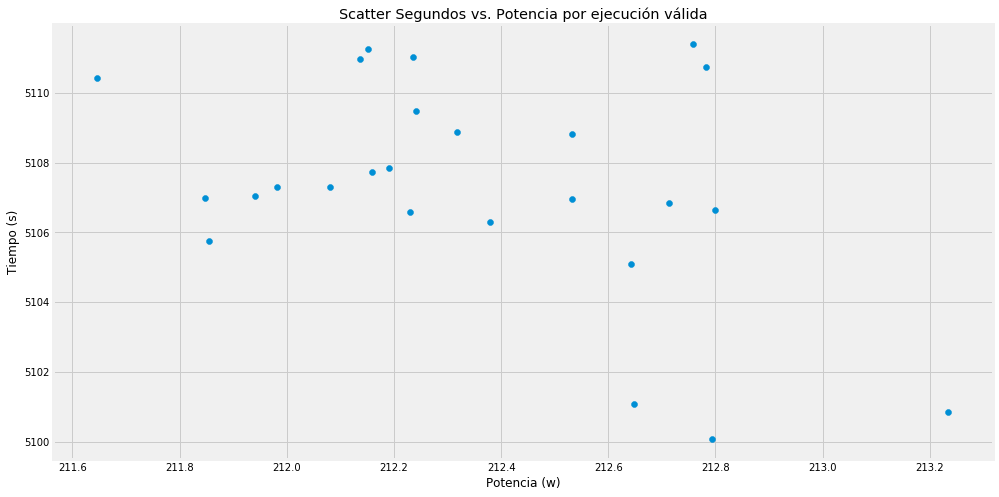

In [52]:
plt.figure(figsize = (15,8))
plt.scatter(ds['pwr'],ds['secs'])
plt.title('Scatter Segundos vs. Potencia por ejecución válida')
plt.xlabel('Potencia (w)')
plt.ylabel('Tiempo (s)')
plt.show()

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

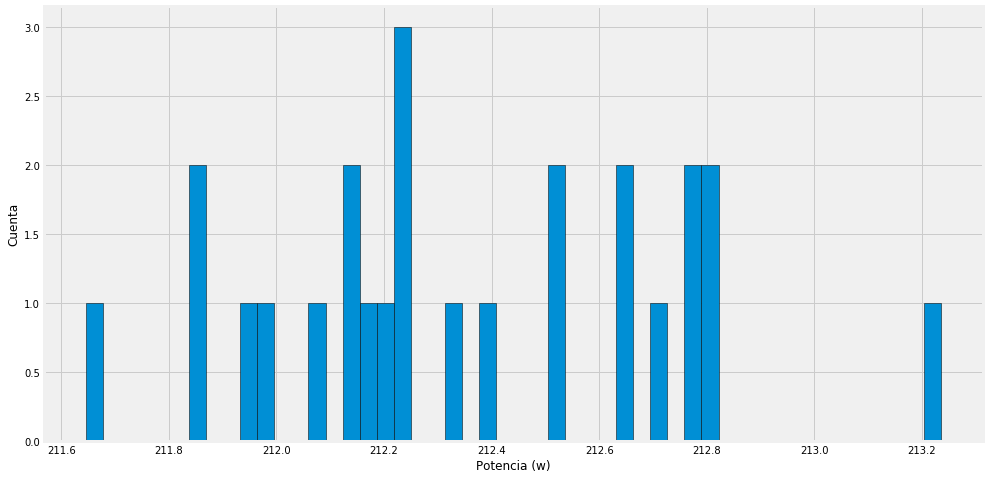

In [53]:
plt.figure(figsize = (15,8))
plt.hist(ds['pwr'],bins=50, edgecolor ='k')
plt.xlabel('Potencia (w)')
plt.ylabel('Cuenta')
plt.show()

Histograma de potencias validas para la simulación

In [54]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

5100.06494140625

In [56]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']<=a[:15].max()][['intento','list']])
ganadores

,intento,list
0,476,"[[0, 210.2859874023964, 26.739637, 344.0415503..."
1,704,"[[0, 195.41728122242898, 25.799864, 344.041550..."
3,1348,"[[0, 208.1618865195439, 26.605383, 344.0415503..."
6,1956,"[[0, 189.04497857387153, 25.431175, 344.041550..."
9,2422,"[[0, 212.4100882852489, 26.87389, 344.04155036..."
11,2618,"[[0, 195.41728122242898, 25.799864, 344.041550..."
13,3894,"[[0, 203.91368475383894, 26.33688, 344.0415503..."
15,5051,"[[0, 191.169079456724, 25.540941, 344.04155036..."
17,5284,"[[0, 212.4100882852489, 26.87389, 344.04155036..."
19,5831,"[[0, 201.78958387098646, 26.202625, 344.041550..."


In [57]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim_2vuelta.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,210.285987,26.739637,344.041550,46.318863,1.596116,3.492273,476
1,1,189.968935,34.358269,13.567297,1.421558,-0.218832,1.574548,476
2,2,199.335657,32.004807,168.993513,19.008915,0.371159,1.731397,476
3,3,199.913785,34.227436,17.331806,1.822938,-0.067596,1.575208,476
4,4,195.503642,33.438927,48.498332,5.221280,0.074144,3.407638,476


In [58]:
df_ganador.describe()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
count,1260.00000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,41.50000,200.299335,33.629355,507.744281,60.779778,-0.047731,-0.587996,4126.066667
std,24.25662,34.146646,6.617297,689.876449,86.814589,1.809585,5.306655,2245.938310
min,0.00000,101.972071,17.630846,12.158278,1.296874,-4.645913,-9.954147,476.000000
25%,20.75000,179.151023,31.621151,25.516494,2.830195,-0.565377,-4.099877,1956.000000
50%,41.50000,204.245358,33.750290,145.726222,16.072968,0.001432,-1.248373,5051.000000
75%,62.25000,223.927099,36.375490,784.964079,76.361347,0.363841,2.888754,6438.000000
max,83.00000,273.693264,49.150597,3454.663686,348.946655,4.950157,9.997376,6775.000000


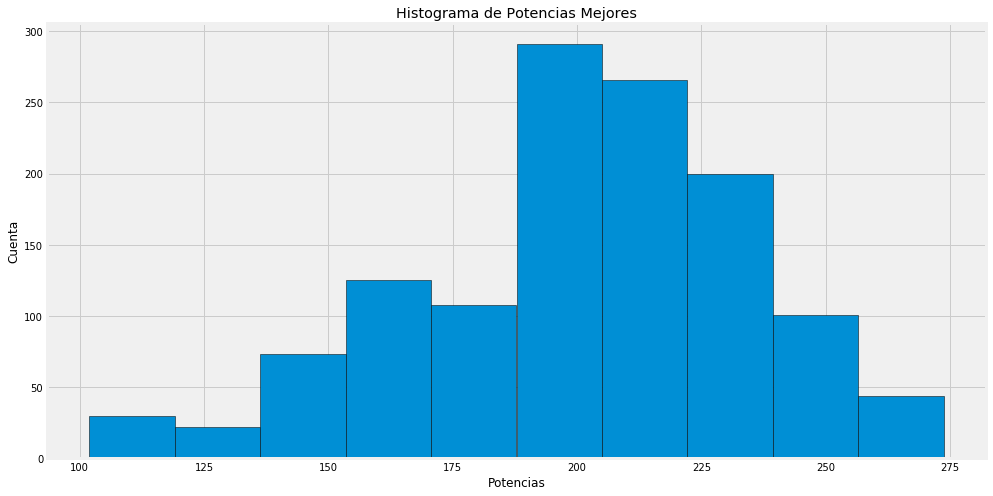

In [59]:
plt.figure(figsize = (15,8))
plt.hist(df_ganador['Potencia'], edgecolor ='k')
plt.title('Histograma de Potencias Mejores')
plt.xlabel('Potencias')
plt.ylabel('Cuenta')
plt.show()

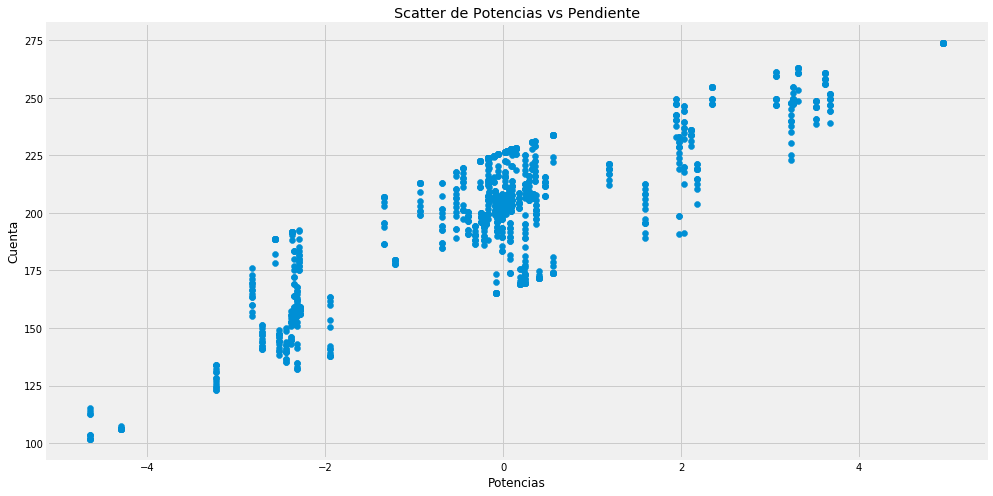

In [60]:
plt.figure(figsize = (15,8))
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])
plt.title('Scatter de Potencias vs Pendiente')
plt.xlabel('Potencias')
plt.ylabel('Cuenta')
plt.show()